ACCIDENTS ROUTIERS EN FRANCE

L’objectif de ce projet est d’essayer de prédire la gravité des accidents routiers en France en se basant sur les données historiques recensées en France entre 2005 et 2023.


Nous avons à notre disposition des datasets regroupant des données recueillies par l'unité des forces de l'ordre qui est intervenue sur le lieu de l'accident, ainsi que la description des bases de données annuelles.

Les fichiers sont séparés en 4 rubriques:

1. La rubrique CARACTERISTIQUES qui décrit les circonstances générales de l’accident
2. La rubrique LIEUX qui décrit le lieu principal de l’accident même si celui-ci s’est déroulé à une
intersection
3. La rubrique VEHICULES impliqués
4. La rubrique USAGERS impliqués

**Etape 1: Découverte des données**

Un premier coup d'oeil aux diverses bases de données et au document de description de ces données met en évidence:

- Une scission dans la manière de renseigner les données à partir de 2019 (exemples: NumAcc renseigné sous AccidentId, Les heures renseignée par tranches de 30 minutes et désormais renseignées à la minute près.....), et des données plus complètes à partir de 2019.
- Le numero d'accident (Num_Acc) est commun à toutes les rubriques.
- Beaucoup trop de lignes pour pouvoir fusionner toutes les rubriques et toutes les années en un seul dataframe (1 247 773 pour les lieux par exemple de 2005 à 2023).
- Des niveaux d'agrégation différents: pour les rubriques véhicules et usagers, plusieurs lignes correspondent à un même accident: une ligne par usager impliqué pour usagers, et une ligne par véhicule impliqué pour véhicules.
- Un nombre important de colonnes (56), avec pour certaines beaucoup de valeurs uniques.
- Nécéssité de préciser notre variable cible: qu'entend-on par "gravité" qui peut être vue d'un point de vue du nombre de véhicules impliqués, du nombre d'usagers impliqués, du nombre de personnes tuées ?

**Etape 2: Précision du sujet**

Après réflexion collective, nous décidons de créer un modèle dont l'objectif serait de permettre à un centre d'appel de secours de déterminer le niveau de gravité d'un accident qui vient de se produire, afin de déclencher le nombre et le type de secours adapté. La variable cible est la gravité.

Dans cette optique, nous prenons deux décisions:

- Se concentrer sur les données de 2019 à 2023, qui sont les plus récentes, et renseignées de manière uniforme. Cela nous permettra de fusionner les 4 rubriques pour relier toutes les variables à notre variable cible, et d'avoir suffisamment de lignes (273226) pour construire notre modèle de machine learning.
- Supprimer les variables qui nous paraissent sans rapport avec la gravité.

**Etape 3: Elaboration d'un dataframe unique de 2019 à 2023**

Dans le but de conserver un maximum de données des datasets initiaux, un travail est nécéssaire sur chacune des tables avant de pouvoir merger le tout dans un dataset unique. Ceci en raison du niveau d'agrégation différent.
La table Usagers est celle ayant le niveau le plus fin d'agrégation et donc celle par laquelle nous commençons, suivie de la table véhicules.
Un premier travail consiste à étudier les différentes colonnes, et les valeurs uniques pour chacune d'elle, et déterminer si c'est une colonne que nous souhaitons conserver ou non (pertinente par rapport à notre objectif).

Un deuxième travail consiste à réflechir sur des premiers regroupements possibles des valeurs uniques contenues dans chacune des colonnes (par exemple: la colonne "surface" détaille initialement si la surface est sèche,mouillée, enneigée, boueuse, flaques d'eau, flaque d'huile,... que nous choisissons de regrouper en seulement 3 valeurs: route sèche, route mouillée/enneigée et autre état, selon la distribution initiale des valeurs).  

Une fois ces deux premières étapes réalisées, un troisième travail consiste à transformer chacune de ces colonnes en nouvelles colonnes correspondant aux valeurs possibles, selon nos regroupements.

L'objectif de ce travail étant de n'avoir en résultat final qu'une seule ligne par accident, tout en ayant conservé un maximum d'informations.
Ainsi, là où nous avions initialement une table comme ceci par exemple avec 2 lignes pour un même accident:

**NumAcc | Surface | Condition Atmospherique | Type de véhicule | Catégorie Usager**

001   |   mouillee  |    brouillard |            Poids Lourd |       conducteur

001   |  mouillee   | brouillard|             Moto     |       Conducteur


Nous avons désormais une ligne par accident et les informations à disposition dans de nouvelles colonnes ( ici à titre d'exemple):

**NumAcc | Surf_Mouillee_enneigee |Surf_sèche | Brouillard | Pluie|  Poids_Lourds | 2roues_3roues  | Cat_conducteur  |  Cat_passager  |**

001  |  1  |  0  |  1  |  0  |  1  |  1  | 2  |  0


Nous décidons par ailleurs de requalifier la gravité de l'accident, là où nuos avions initialement une gravité pour chaque usager ( indemne, blessé léger, blessé hospitalisé ou tué)
Nous conservons la gravité la plus élevée, ainsi nous avons 3 niveaux de gravité différents, blessé léger (2), blessé hospitalisé (3), et mortel (4).

(Nous n'avons pas d'accident n'ayant que des indemnes: en effet, comme précisé dans le descriptif à notre disposition, ne sont recensés que les accidents impliquant au moins un véhicule et ayant fait au *moins une victime ayant nécessité des soins*).



In [ ]:
# Montage du drive

from google.colab import drive
import pandas as pd
import os
from io import StringIO
# Monter Google Drive
drive.mount('/content/drive', force_remount= True) #force_remount = True permet d'avoir un fichier mis à jour si modifs sur google drive


################################ Création all_data_vehicules (2019-2023) #####################################
# Chemin vers le dossier contenant les fichiers CSV
folder_path = '/content/drive/My Drive/Datascientest/Dataset_perso/Vehicules/Vehicules_par_annee'

# Lister tous les fichiers dans le dossier
all_files = os.listdir(folder_path)

# Liste pour stocker les DataFrames
dataframes_vehicules = []

# Itérer à travers chaque fichier
for file in all_files:
    file_path = os.path.join(folder_path, file)

    if file.endswith('.csv'):
        # Lire le fichier comme texte
        with open(file_path, 'r') as f:
            content = f.read()

        # Remplacer plusieurs types de séparateurs par un séparateur unique (par exemple, une tabulation)
        content = content.replace(',', '\t').replace(';', '\t').replace('|', '\t')  # Ajoutez d'autres séparateurs si nécessaire

        # Utiliser pd.read_csv avec le séparateur commun
        df_vehicules = pd.read_csv(StringIO(content), sep='\t', low_memory=False) # permet de mieux gérer les données de divers types pour une même variable


        # Ajouter le DataFrame à la liste
        dataframes_vehicules.append(df_vehicules)

# Concaténer tous les DataFrames
all_data_vehicules_2019_2023 = pd.concat(dataframes_vehicules, ignore_index=True)
#enregistrer dans le fichier concaténé dans le drive

all_data_vehicules_2019_2023.to_csv('/content/drive/My Drive/Datascientest/Dataset_perso/all_data_vehicules_2019_2023.csv', index=False)




################################Création on du fichier all_data_usagers_2019_2023 ############################################################################
# Chemin vers le dossier contenant les fichiers CSV
folder_path = '/content/drive/My Drive/Datascientest/Dataset_perso/Usagers'

# Lister tous les fichiers dans le dossier
all_files = os.listdir(folder_path)

# Liste pour stocker les DataFrames
dataframes_usagers = []

# Itérer à travers chaque fichier
for file in all_files:
    file_path = os.path.join(folder_path, file)

    if file.endswith('.csv'):
        # Lire le fichier comme texte
        with open(file_path, 'r') as f:
            content = f.read()

        # Remplacer plusieurs types de séparateurs par un séparateur unique (par exemple, une tabulation)
        content = content.replace(',', '\t').replace(';', '\t').replace('|', '\t')  # Ajoutez d'autres séparateurs si nécessaire

        # Utiliser pd.read_csv avec le séparateur commun
        df_usagers = pd.read_csv(StringIO(content), sep='\t', low_memory=False) # permet de mieux gérer les données de divers types pour une même variable


        # Ajouter le DataFrame à la liste
        dataframes_usagers.append(df_usagers)

# Concaténer tous les DataFrames
all_data_usagers_2019_2023 = pd.concat(dataframes_usagers, ignore_index=True)

all_data_usagers_2019_2023.to_csv('/content/drive/My Drive/Datascientest/Dataset_perso/all_data_usagers_2019_2023.csv', index=False)


#################################### Création all_data_carac_2019_2023 #################################################################
# Chemin vers le dossier contenant les fichiers CSV
folder_path = '/content/drive/My Drive/Datascientest/Dataset_perso/Caractéristiques'

# Lister tous les fichiers dans le dossier
all_files = os.listdir(folder_path)

# Liste pour stocker les DataFrames
dataframes_carac = []

# Itérer à travers chaque fichier
for file in all_files:
    file_path = os.path.join(folder_path, file)

    if file.endswith('.csv'):
        # Lire le fichier comme texte
        with open(file_path, 'r') as f:
            content = f.read()

        # Remplacer plusieurs types de séparateurs par un séparateur unique (par exemple, une tabulation)
        content = content.replace(',', '\t').replace(';', '\t').replace('|', '\t')  # Ajoutez d'autres séparateurs si nécessaire

        # Utiliser pd.read_csv avec le séparateur commun
        df_carac = pd.read_csv(StringIO(content), sep='\t', low_memory=False) # permet de mieux gérer les données de divers types pour une même variable


        # Ajouter le DataFrame à la liste
        dataframes_carac.append(df_carac)

# Concaténer tous les DataFrames
all_data_carac_2019_2023 = pd.concat(dataframes_carac, ignore_index=True)

all_data_carac_2019_2023.to_csv('/content/drive/My Drive/Datascientest/Dataset_perso/all_data_carac_2019_2023.csv', index=False)

########################################### Création all_data_lieux_2019_2023 ######################################################################
# Chemin vers le dossier contenant les fichiers CSV
folder_path = '/content/drive/My Drive/Datascientest/Dataset_perso/Lieux'

# Lister tous les fichiers dans le dossier
all_files = os.listdir(folder_path)

# Liste pour stocker les DataFrames
dataframes_lieux = []

# Itérer à travers chaque fichier
for file in all_files:
    file_path = os.path.join(folder_path, file)

    if file.endswith('.csv'):
        # Lire le fichier comme texte
        with open(file_path, 'r') as f:
            content = f.read()

        # Remplacer plusieurs types de séparateurs par un séparateur unique (par exemple, une tabulation)
        content = content.replace(',', '\t').replace(';', '\t').replace('|', '\t')  # Ajoutez d'autres séparateurs si nécessaire

        # Utiliser pd.read_csv avec le séparateur commun
        df_lieux = pd.read_csv(StringIO(content), sep='\t', low_memory=False) # permet de mieux gérer les données de divers types pour une même variable


        # Ajouter le DataFrame à la liste
        dataframes_lieux.append(df_lieux)

# Concaténer tous les DataFrames
all_data_lieux_2019_2023 = pd.concat(dataframes_lieux, ignore_index=True)
all_data_lieux_2019_2023.to_csv('/content/drive/My Drive/Datascientest/Dataset_perso/all_data_lieux_2019_2023.csv', index=False)


Mounted at /content/drive


Nous allons maintenant créer un DataFrame qui regroupe les informations des quatre tables obtenues.

Au cours de la création de ce DataFrame, nous supprimerons les colonnes suivantes, que nous détermminons non pertinentes pour notre problématique:'lum', 'com', 'adr', 'voie', 'v1', 'v2', 'circ','vosp', 'prof', 'pr', 'pr1', 'plan', 'lartpc', 'larrout', 'infra', 'situ', 'id_vehicule', 'num_veh', 'senc', 'occutc', 'id_usager', 'trajet', 'locp', 'actp', 'etatp'

1. **Travail sur la table Usagers qui est celle avec le niveau d'agrégation le plus fin (1 ligne par usager, total 619971 lignes)**




In [ ]:
df_usag=pd.read_csv("/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/all_data_usagers_2019_2023.csv")
df_usag.info()
df_usag.head(10)

<ipython-input-4-f018ebf22501>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_usag=pd.read_csv("/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/all_data_usagers_2019_2023.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619971 entries, 0 to 619970
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      619971 non-null  int64  
 1   id_usager    381699 non-null  object 
 2   id_vehicule  619971 non-null  object 
 3   num_veh      619971 non-null  object 
 4   place        619971 non-null  int64  
 5   catu         619971 non-null  int64  
 6   grav         619971 non-null  int64  
 7   sexe         619971 non-null  int64  
 8   an_nais      611432 non-null  float64
 9   trajet       619971 non-null  int64  
 10  secu1        619971 non-null  int64  
 11  secu2        619971 non-null  int64  
 12  secu3        619971 non-null  int64  
 13  locp         619971 non-null  int64  
 14  actp         619971 non-null  object 
 15  etatp        619971 non-null  int64  
dtypes: float64(1), int64(11), object(4)
memory usage: 75.7+ MB


,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202200000001,1 099 700,813 952,A01,1,1,3,1,2008.0,5,2,8,-1,-1,-1,-1
1,202200000001,1 099 701,813 953,B01,1,1,1,1,1948.0,5,1,8,-1,-1,-1,-1
2,202200000002,1 099 698,813 950,B01,1,1,4,1,1988.0,9,1,0,-1,0,0,-1
3,202200000002,1 099 699,813 951,A01,1,1,1,1,1970.0,4,1,0,-1,0,0,-1
4,202200000003,1 099 696,813 948,A01,1,1,1,1,2002.0,0,1,0,-1,-1,-1,-1
5,202200000003,1 099 697,813 949,B01,1,1,4,2,1987.0,9,1,0,-1,-1,-1,-1
6,202200000004,1 099 694,813 947,A01,1,1,1,2,2000.0,0,1,8,-1,-1,-1,-1
7,202200000004,1 099 695,813 947,A01,10,3,4,2,1967.0,5,0,-1,-1,2,3,1
8,202200000005,1 099 692,813 945,B01,1,1,1,2,1975.0,0,1,0,-1,-1,-1,-1
9,202200000005,1 099 693,813 946,A01,1,1,4,2,1996.0,0,1,0,-1,-1,-1,-1


In [ ]:
## Groupby par numéro d'accident et d'id véhicule en faisant le comptage du nombre d'usager
df_nbr_usagers=df_usag.groupby(["Num_Acc","id_vehicule"]).agg(nb_usagers=("Num_Acc","count")).reset_index()
df_nbr_usagers
### Merge de df usagers initial et df_nbr_usagers pour avoir la nouvelle colonne comportant le nombre d'usager
df_usag2=pd.merge(df_usag,df_nbr_usagers,on=["Num_Acc","id_vehicule"])
df_usag2

,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp,nb_usagers
0,202200000001,1 099 700,813 952,A01,1,1,3,1,2008.0,5,2,8,-1,-1,-1,-1,1
1,202200000001,1 099 701,813 953,B01,1,1,1,1,1948.0,5,1,8,-1,-1,-1,-1,1
2,202200000002,1 099 698,813 950,B01,1,1,4,1,1988.0,9,1,0,-1,0,0,-1,1
3,202200000002,1 099 699,813 951,A01,1,1,1,1,1970.0,4,1,0,-1,0,0,-1,1
4,202200000003,1 099 696,813 948,A01,1,1,1,1,2002.0,0,1,0,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619966,202000047743,NaN,154 658 351,B01,4,2,4,1,2011.0,5,1,0,-1,0,0,-1,2
619967,202000047743,NaN,154 658 351,B01,1,1,4,2,1981.0,5,1,0,-1,0,0,-1,2
619968,202000047743,NaN,154 658 352,A01,1,1,4,1,1998.0,9,1,0,-1,0,0,-1,1
619969,202000047744,NaN,154 658 350,A01,1,1,1,1,1967.0,9,2,0,-1,-1,-1,-1,2


In [ ]:
### Transformation de la colonne "gravité" de sorte à obtenir, pour chaque usager, des nouvelles colonnes comptabilisant le nombre de personne par gravité
df_usag_with_dummies_grav = pd.get_dummies(df_usag2, columns=['grav'], dtype="int")
df_usag3=df_usag_with_dummies_grav
df_usag3

,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,sexe,an_nais,trajet,secu1,...,secu3,locp,actp,etatp,nb_usagers,grav_-1,grav_1,grav_2,grav_3,grav_4
0,202200000001,1 099 700,813 952,A01,1,1,1,2008.0,5,2,...,-1,-1,-1,-1,1,0,0,0,1,0
1,202200000001,1 099 701,813 953,B01,1,1,1,1948.0,5,1,...,-1,-1,-1,-1,1,0,1,0,0,0
2,202200000002,1 099 698,813 950,B01,1,1,1,1988.0,9,1,...,-1,0,0,-1,1,0,0,0,0,1
3,202200000002,1 099 699,813 951,A01,1,1,1,1970.0,4,1,...,-1,0,0,-1,1,0,1,0,0,0
4,202200000003,1 099 696,813 948,A01,1,1,1,2002.0,0,1,...,-1,-1,-1,-1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619966,202000047743,NaN,154 658 351,B01,4,2,1,2011.0,5,1,...,-1,0,0,-1,2,0,0,0,0,1
619967,202000047743,NaN,154 658 351,B01,1,1,2,1981.0,5,1,...,-1,0,0,-1,2,0,0,0,0,1
619968,202000047743,NaN,154 658 352,A01,1,1,1,1998.0,9,1,...,-1,0,0,-1,1,0,0,0,0,1
619969,202000047744,NaN,154 658 350,A01,1,1,1,1967.0,9,2,...,-1,-1,-1,-1,2,0,1,0,0,0


In [ ]:
# Travail sur la colonne "catu"  pour obtenir une nouvelle colonne correspondant à chaque catégorie usager

df_usag_catu=pd.get_dummies(df_usag3,columns=["catu"],dtype="int")
df_usag_catu
df_usag4=df_usag_catu.groupby(['Num_Acc',"id_vehicule"]).agg( usager_count=('Num_Acc', 'count'),grav_minus1=('grav_-1', 'sum'), grav_1=('grav_1', 'sum'), grav_2=('grav_2', 'sum'), grav_3=('grav_3', 'sum'), grav_4=('grav_4', 'sum'),catu_1=("catu_1","sum"),catu_2=("catu_2","sum"),catu_3=("catu_3","sum")).reset_index()
df_usag4=df_usag4.rename(columns={"grav_minus1":"grav_non_renseigné","grav_1":"indemne","grav_2":"tué","grav_3":"blessé_hospitalisé","grav_4":"blessé_léger","catu_1":"conducteur","catu_2":"passager","catu_3":"pieton"})
df_usag4

,Num_Acc,id_vehicule,usager_count,grav_non_renseigné,indemne,tué,blessé_hospitalisé,blessé_léger,conducteur,passager,pieton
0,201900000001,138 306 524,2,0,0,0,0,2,1,1,0
1,201900000001,138 306 525,1,0,1,0,0,0,1,0,0
2,201900000002,138 306 523,1,0,0,0,0,1,1,0,0
3,201900000003,138 306 520,2,0,1,0,0,1,1,1,0
4,201900000003,138 306 521,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
463179,202300054820,155 583 348,2,0,0,0,0,2,1,1,0
463180,202300054821,155 583 346,1,0,0,0,0,1,1,0,0
463181,202300054821,155 583 347,1,0,1,0,0,0,1,0,0
463182,202300054822,155 583 344,2,0,2,0,0,0,1,1,0


In [ ]:
# Travail sur les 3 colonnes SECU, et décision de regrouper les 3 informations, en sommant les types de sécu des 3 colonnes lorsqu'ils sont identiques
df_secu=pd.get_dummies(df_usag,columns=["secu1","secu2","secu3"],dtype="int")
df_secu["total_secu-1"]=df_secu[['secu1_-1', 'secu2_-1', 'secu3_-1']].sum(axis=1)
df_secu['total_secu0'] = df_secu[['secu1_0', 'secu2_0', 'secu3_0']].sum(axis=1)
df_secu['total_secu1'] = df_secu[['secu1_1', 'secu2_1', 'secu3_1']].sum(axis=1)
df_secu['total_secu2'] = df_secu[['secu1_2', 'secu2_2', 'secu3_2']].sum(axis=1)
df_secu['total_secu3'] = df_secu[['secu1_3', 'secu2_3', 'secu3_3']].sum(axis=1)
df_secu['total_secu4'] = df_secu[['secu1_4', 'secu2_4', 'secu3_4']].sum(axis=1)
df_secu["total_secu5"] = df_secu[['secu1_5', 'secu2_5', 'secu3_5']].sum(axis=1)
df_secu["total_secu6"] = df_secu[['secu1_6', 'secu2_6', 'secu3_6']].sum(axis=1)
df_secu["total_secu7"] = df_secu[['secu1_7', 'secu2_7', 'secu3_7']].sum(axis=1)
df_secu["total_secu8"] = df_secu[['secu1_8', 'secu2_8', 'secu3_8']].sum(axis=1)
df_secu["total_secu9"] = df_secu[['secu1_9', 'secu2_9', 'secu3_9']].sum(axis=1)
df_secu.head(50)

df_secu=df_secu[["Num_Acc","id_usager","id_vehicule","total_secu-1","total_secu0","total_secu1","total_secu2","total_secu3","total_secu4","total_secu5","total_secu6","total_secu7","total_secu8","total_secu9"]]
df_secu

,Num_Acc,id_usager,id_vehicule,total_secu-1,total_secu0,total_secu1,total_secu2,total_secu3,total_secu4,total_secu5,total_secu6,total_secu7,total_secu8,total_secu9
0,202200000001,1 099 700,813 952,1,0,0,1,0,0,0,0,0,1,0
1,202200000001,1 099 701,813 953,1,0,1,0,0,0,0,0,0,1,0
2,202200000002,1 099 698,813 950,1,1,1,0,0,0,0,0,0,0,0
3,202200000002,1 099 699,813 951,1,1,1,0,0,0,0,0,0,0,0
4,202200000003,1 099 696,813 948,1,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619966,202000047743,NaN,154 658 351,1,1,1,0,0,0,0,0,0,0,0
619967,202000047743,NaN,154 658 351,1,1,1,0,0,0,0,0,0,0,0
619968,202000047743,NaN,154 658 352,1,1,1,0,0,0,0,0,0,0,0
619969,202000047744,NaN,154 658 350,1,1,0,1,0,0,0,0,0,0,0


In [ ]:
## Regroupement du DF_Secu par num acc et id vehicule pour obtenir 463183 lignes qui correspond au nombre de vehicules total dans le data set, en vue de travailler ensuite le dataset vehicules #########

df_secu_final=df_secu.groupby(["Num_Acc","id_vehicule"]).agg(total_secu_non_renseigné=("total_secu-1","sum"),total_sans_secu=("total_secu0","sum"),total_ceinture=("total_secu1","sum"),total_casque=("total_secu2","sum"),total_secu_enfant=("total_secu3","sum"), total_gilet=("total_secu4","sum"), total_airbag=("total_secu5","sum"), total_gants=("total_secu6","sum"),total_gants_airbag=("total_secu7","sum"),total_non_deter=("total_secu8","sum"),total_autre=("total_secu9","sum")).reset_index()
df_secu_final


,Num_Acc,id_vehicule,total_secu_non_renseigné,total_sans_secu,total_ceinture,total_casque,total_secu_enfant,total_gilet,total_airbag,total_gants,total_gants_airbag,total_non_deter,total_autre
0,201900000001,138 306 524,2,2,2,0,0,0,0,0,0,0,0
1,201900000001,138 306 525,1,1,1,0,0,0,0,0,0,0,0
2,201900000002,138 306 523,1,1,1,0,0,0,0,0,0,0,0
3,201900000003,138 306 520,2,2,2,0,0,0,0,0,0,0,0
4,201900000003,138 306 521,1,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
463179,202300054820,155 583 348,2,2,2,0,0,0,0,0,0,0,0
463180,202300054821,155 583 346,1,1,0,1,0,0,0,0,0,0,0
463181,202300054821,155 583 347,1,1,1,0,0,0,0,0,0,0,0
463182,202300054822,155 583 344,4,0,2,0,0,0,0,0,0,0,0


In [ ]:
## Merge de df_secu_final et df_usag4 précédent pour obtenir 63183 lignes
df_usag5=pd.merge(df_usag4,df_secu_final,on=["Num_Acc","id_vehicule"])
df_usag5

,Num_Acc,id_vehicule,usager_count,grav_non_renseigné,indemne,tué,blessé_hospitalisé,blessé_léger,conducteur,passager,...,total_sans_secu,total_ceinture,total_casque,total_secu_enfant,total_gilet,total_airbag,total_gants,total_gants_airbag,total_non_deter,total_autre
0,201900000001,138 306 524,2,0,0,0,0,2,1,1,...,2,2,0,0,0,0,0,0,0,0
1,201900000001,138 306 525,1,0,1,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,0
2,201900000002,138 306 523,1,0,0,0,0,1,1,0,...,1,1,0,0,0,0,0,0,0,0
3,201900000003,138 306 520,2,0,1,0,0,1,1,1,...,2,2,0,0,0,0,0,0,0,0
4,201900000003,138 306 521,1,0,0,0,0,1,1,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463179,202300054820,155 583 348,2,0,0,0,0,2,1,1,...,2,2,0,0,0,0,0,0,0,0
463180,202300054821,155 583 346,1,0,0,0,0,1,1,0,...,1,0,1,0,0,0,0,0,0,0
463181,202300054821,155 583 347,1,0,1,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,0
463182,202300054822,155 583 344,2,0,2,0,0,0,1,1,...,0,2,0,0,0,0,0,0,0,0


In [ ]:
## Travail surla colonne"PLACE" en décision de regrouper les modalités en 5 catégories: conducteur, passager avant, passager arriere, passager milieu et piéton. Création d'un df_usag_place à merger ensuite au df_usag5 précédent
## L'info Conducteur est redondante puisque c'est une information que nous avions déja grâce à la colonne CATU, de même pour Pieton  #######
df_usag["place_conducteur"]=0
df_usag["pax_Avant"]=0
df_usag["pax_arriere"]=0
df_usag["pax_milieu"]=0
df_usag["pieton"]=0
def replace_place(row):
  if row['place'] == 1:
    row['place_conducteur'] += 1
  if row["place"] in [2,6]:
    row["pax_Avant"]+=1
  if row["place"] in [3,4,5]:
    row["pax_arriere"]+=1
  if row["place"] in [7,8,9]:
    row["pax_milieu"]+=1
  if row["place"]==10:
    row["pieton"]+=1
  return row

df_usag_place = df_usag.apply(replace_place, axis=1)

df_usag_place=df_usag_place[["Num_Acc","id_vehicule","id_usager","place","place_conducteur","pax_Avant","pax_arriere","pax_milieu","pieton"]]
df_final_place=df_usag_place.groupby(["Num_Acc","id_vehicule"]).agg(conducteur=("place_conducteur","sum"),pax_AV=("pax_Avant","sum"),pax_AR=("pax_arriere","sum"),pax_Milieu=("pax_milieu","sum"),pieton=("pieton","sum")).reset_index()
df_final_place.head(50) # 463184 lignes
df_usag6=df_usag5.merge(df_final_place,on=["Num_Acc","id_vehicule"])

# je renomme les colonnes pour une meilleure lisibilité
df_usag6=df_usag6.rename({"conducteur_x":"catu_conducteur","conducteur_y":"place_conducteur"},axis=1)

df_usag6

,Num_Acc,id_vehicule,usager_count,grav_non_renseigné,indemne,tué,blessé_hospitalisé,blessé_léger,catu_conducteur,passager,...,total_airbag,total_gants,total_gants_airbag,total_non_deter,total_autre,place_conducteur,pax_AV,pax_AR,pax_Milieu,pieton_y
0,201900000001,138 306 524,2,0,0,0,0,2,1,1,...,0,0,0,0,0,1,1,0,0,0
1,201900000001,138 306 525,1,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,201900000002,138 306 523,1,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
3,201900000003,138 306 520,2,0,1,0,0,1,1,1,...,0,0,0,0,0,1,1,0,0,0
4,201900000003,138 306 521,1,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463179,202300054820,155 583 348,2,0,0,0,0,2,1,1,...,0,0,0,0,0,1,1,0,0,0
463180,202300054821,155 583 346,1,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
463181,202300054821,155 583 347,1,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
463182,202300054822,155 583 344,2,0,2,0,0,0,1,1,...,0,0,0,0,0,1,1,0,0,0


In [ ]:
## Encodage de la colonne sexe afin d'obtenir 3 colonnes distinctes homme/femme /non renseigné
df_sex=pd.get_dummies(df_usag,columns=["sexe"],dtype=int)
df_sex=df_sex[["Num_Acc","id_vehicule","id_usager","sexe_1","sexe_2","sexe_-1"]]

df_sex=df_sex.groupby(["Num_Acc","id_vehicule"]).agg(homme=("sexe_1","sum"),femme=("sexe_2","sum"),sex_non_renseigné=("sexe_-1","sum")).reset_index()
df_sex

,Num_Acc,id_vehicule,homme,femme,sex_non_renseigné
0,201900000001,138 306 524,0,2,0
1,201900000001,138 306 525,1,0,0
2,201900000002,138 306 523,0,1,0
3,201900000003,138 306 520,1,1,0
4,201900000003,138 306 521,1,0,0
...,...,...,...,...,...
463179,202300054820,155 583 348,1,1,0
463180,202300054821,155 583 346,1,0,0
463181,202300054821,155 583 347,0,1,0
463182,202300054822,155 583 344,0,2,0


In [ ]:
################Je rajoute df_sex au df_usag6 et sauve mon df_usag7 qui est le df final pour la table usagers.  ###############################
df_usag7=df_usag6.merge(df_sex,on=["Num_Acc","id_vehicule"])

df_usag7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463184 entries, 0 to 463183
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Num_Acc                   463184 non-null  int64 
 1   id_vehicule               463184 non-null  object
 2   usager_count              463184 non-null  int64 
 3   grav_non_renseigné        463184 non-null  int64 
 4   indemne                   463184 non-null  int64 
 5   tué                       463184 non-null  int64 
 6   blessé_hospitalisé        463184 non-null  int64 
 7   blessé_léger              463184 non-null  int64 
 8   catu_conducteur           463184 non-null  int64 
 9   passager                  463184 non-null  int64 
 10  pieton_x                  463184 non-null  int64 
 11  total_secu_non_renseigné  463184 non-null  int64 
 12  total_sans_secu           463184 non-null  int64 
 13  total_ceinture            463184 non-null  int64 
 14  tota

,Num_Acc,id_vehicule,an_nais,annee,age
0,202200000001,813 952,2008.0,2022,14.0
1,202200000001,813 953,1948.0,2022,74.0
2,202200000002,813 950,1988.0,2022,34.0
3,202200000002,813 951,1970.0,2022,52.0
4,202200000003,813 948,2002.0,2022,20.0
...,...,...,...,...,...
619966,202000047743,154 658 351,2011.0,2020,9.0
619967,202000047743,154 658 351,1981.0,2020,39.0
619968,202000047743,154 658 352,1998.0,2020,22.0
619969,202000047744,154 658 350,1967.0,2020,53.0


<ipython-input-14-abd7e66a8a04>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_age, x='age',palette="viridis")


<Axes: xlabel='age', ylabel='count'>

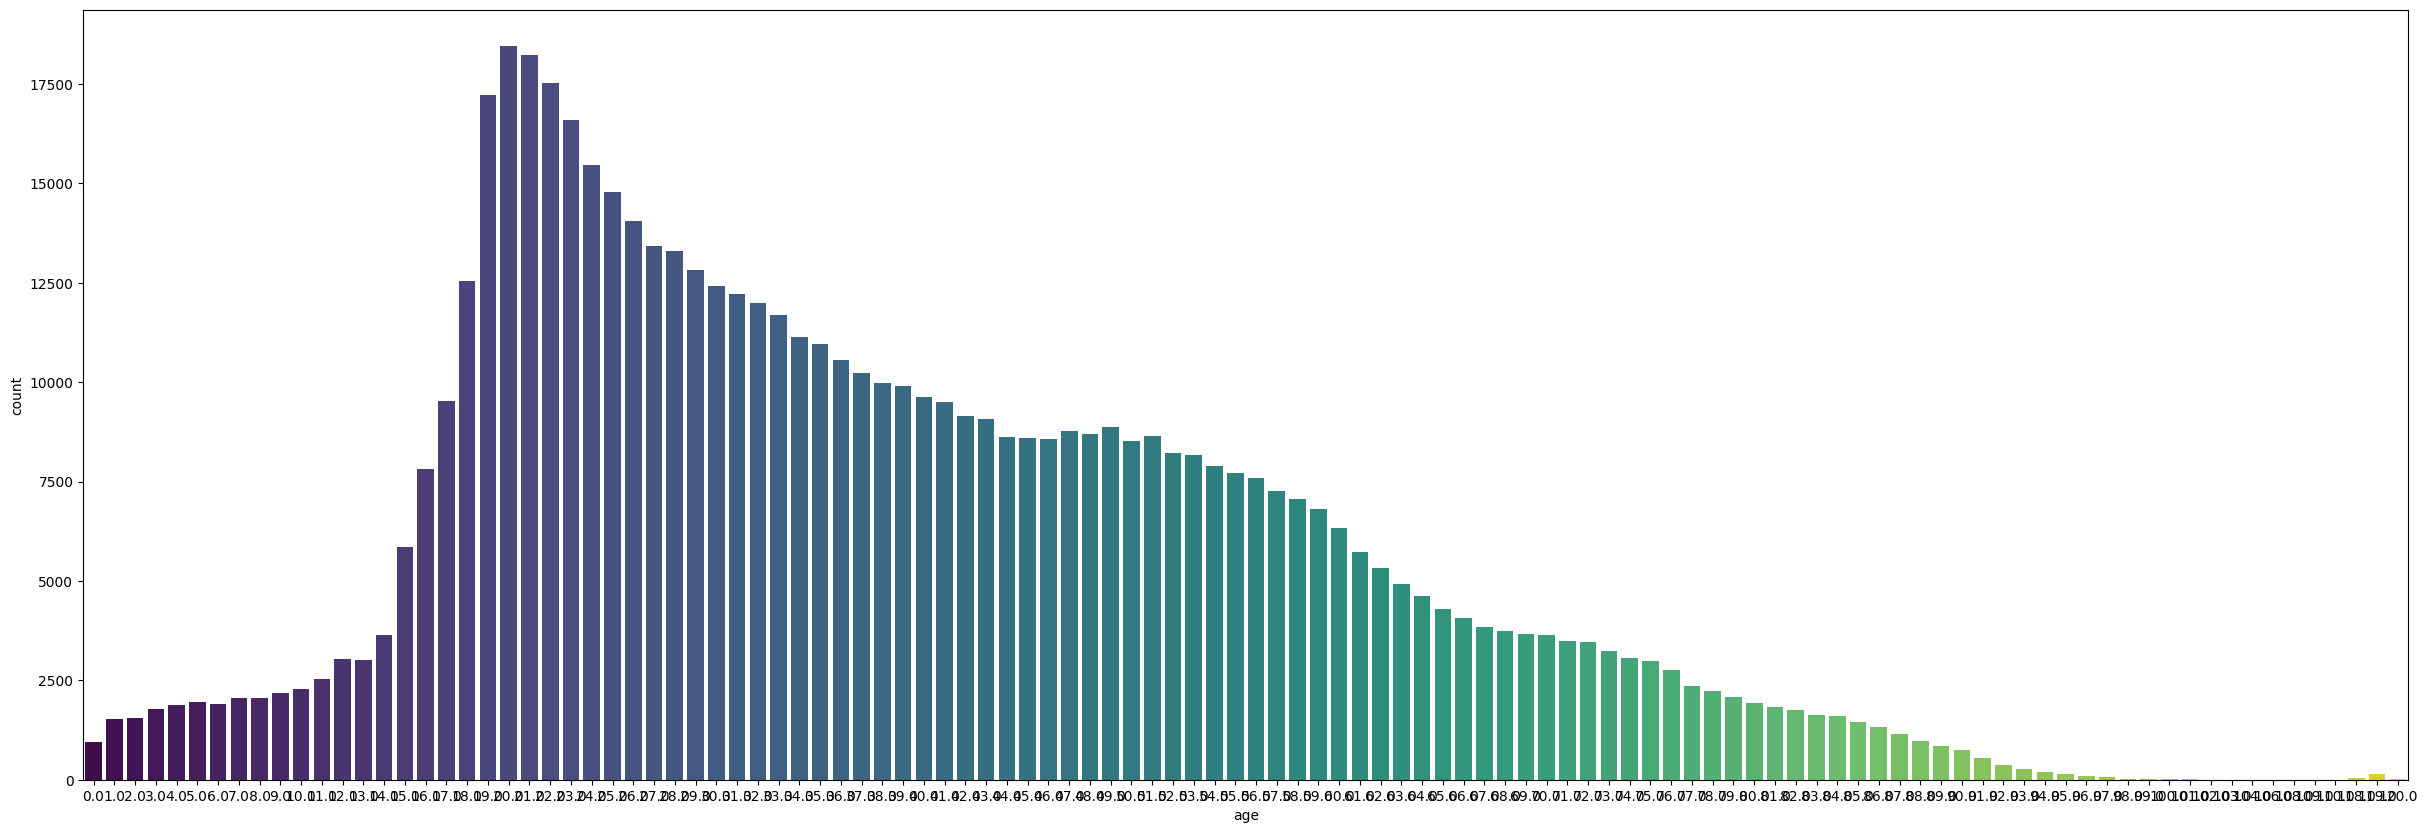

In [ ]:
## Ajout d'une variable age
df_usag["annee"]=df_usag["Num_Acc"].apply(lambda x: str(x)[:4])   # je rajoute une colonne "année"
df_usag["annee"]=df_usag["annee"].astype(int)
df_usag["age"]=df_usag['annee']-df_usag['an_nais']# je rajoute une colonne année de naissance de l'usager

df_age=df_usag[["Num_Acc","id_vehicule","an_nais","annee","age"]]
display(df_age)

# Etude de la distribution selon les ages pour établir des classes d'âge pertinentes
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(30,10))
sns.countplot(data=df_age, x='age',palette="viridis")

In [ ]:
# Etude des outliers de la variable âge (on constate sur le graphique qu'il y a un certain nombre d'accidents pour des personnes de plus de 100ans, regrardons en détail combien il y en a
print("L'âge médian est de ", df_age['age'].median(), "ans")

Q1 = df_age['age'].quantile(0.25)  # Premier quartile (25e percentile)
Q3 = df_age['age'].quantile(0.75)  # Troisième quartile (75e percentile)
IQR = Q3 - Q1                  # IQR (Interquartile Range)

# Définir les limites pour identifier les outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

print("lower limit", lower_limit) # Elle n'a pas de sens
print("upper limit", upper_limit)
# Identifier les outliers
outliers = df_age[ (df_age['age'] > upper_limit)]

print('il y a ', outliers.size, 'outliers')

# On va rajouter une tranche d'age (supérieure à 96), pour ensuite la supprimer sans supprimer les autres informations concernant ces usagers.



L'âge médian est de  35.0 ans
lower limit -20.5
upper limit 95.5
il y a  2060 outliers


In [ ]:
# Catégorisation de l'âge en 4 tranches

df_age["0-17"]=0
df_age["18-60"]=0
df_age["61-95"]=0
df_age[">96"]=0

def tranche_age(row):
  if row['age'] <= 17:
    row['0-17'] += 1
  if 18<row["age"] <60:
    row["18-60"]+=1
  if row["age"]>=61:
    row["61-95"]+=1
  if row["age"]>=96:
    row[">96"]+=1
  return row

df_age_bins = df_age.apply(tranche_age, axis=1)

df_age_final=df_age_bins.groupby(["Num_Acc","id_vehicule"]).agg({"0-17":"sum","18-60":"sum","61-95":"sum", ">96":"sum"}).reset_index()

<ipython-input-16-70e322761fbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age["0-17"]=0
<ipython-input-16-70e322761fbf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age["18-60"]=0
<ipython-input-16-70e322761fbf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [ ]:
df_age_final.groupby(["Num_Acc","id_vehicule"]).agg({"0-17":"sum","18-60":"sum","61-95":"sum",">96": "sum"}).reset_index()

,Num_Acc,id_vehicule,0-17,18-60,61-95,>96
0,201900000001,138 306 524,1,1,0,0
1,201900000001,138 306 525,0,0,0,0
2,201900000002,138 306 523,0,1,0,0
3,201900000003,138 306 520,0,1,1,0
4,201900000003,138 306 521,0,1,0,0
...,...,...,...,...,...,...
463179,202300054820,155 583 348,0,1,1,0
463180,202300054821,155 583 346,0,1,0,0
463181,202300054821,155 583 347,0,1,0,0
463182,202300054822,155 583 344,0,2,0,0


In [ ]:
# Merge de df_usag7 et df_age
df_usag8=df_usag7.merge(df_age_final,on=["Num_Acc","id_vehicule"])
df_usag8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463184 entries, 0 to 463183
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Num_Acc                   463184 non-null  int64 
 1   id_vehicule               463184 non-null  object
 2   usager_count              463184 non-null  int64 
 3   grav_non_renseigné        463184 non-null  int64 
 4   indemne                   463184 non-null  int64 
 5   tué                       463184 non-null  int64 
 6   blessé_hospitalisé        463184 non-null  int64 
 7   blessé_léger              463184 non-null  int64 
 8   catu_conducteur           463184 non-null  int64 
 9   passager                  463184 non-null  int64 
 10  pieton_x                  463184 non-null  int64 
 11  total_secu_non_renseigné  463184 non-null  int64 
 12  total_sans_secu           463184 non-null  int64 
 13  total_ceinture            463184 non-null  int64 
 14  tota

In [ ]:
## Enregistrement de df_usag8 qui représente le df_usagers finalisé

df_usag8.to_csv("/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/df_usag8.csv", index=False)

df_usagers_final=pd.read_csv("/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/df_usag8.csv")

2.  **La 2ème étape consiste à travailler sur la table véhicules afin de pouvoir la merger à la table USAGERS précédente qui compte 1 ligne par véhicule**


In [ ]:
## Importation de la table Véhicules - 1 ligne par véhicule impliqué
import pandas as pd
df_veh=pd.read_csv("/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/all_data_vehicules_2019_2023.csv")
df_veh.info()  # 467169 lignes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467169 entries, 0 to 467168
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      467169 non-null  int64  
 1   id_vehicule  467169 non-null  object 
 2   num_veh      467169 non-null  object 
 3   senc         467169 non-null  int64  
 4   catv         467169 non-null  int64  
 5   obs          467169 non-null  int64  
 6   obsm         467169 non-null  int64  
 7   choc         467169 non-null  int64  
 8   manv         467169 non-null  int64  
 9   motor        467169 non-null  int64  
 10  occutc       3912 non-null    float64
dtypes: float64(1), int64(8), object(2)
memory usage: 39.2+ MB


In [ ]:
## Pour les colonnes Obsm et Obs, on regarde la distribution des valeurs
print(df_veh["obsm"].value_counts())   # la modalité 2 signifie qu'un autre véhicule a été heurté, 0 signifie aucun obstacle heurté et 1 signifie un piéton
print(df_veh["obs"].value_counts())    # 0 signifie aucun obstacle fixe heurté, 1 signifie un autre véhicule en stationnement

# On choisit de transformer ces 2 colonnes en binaire: 0 sans obs ; 1 si obstacle. Dans l'idée d'un modèle qui prédirait la gravité de l'accident grâce à un boîtier integré dans le vehicule, on juge que le type d'obstacle percuté n'est pas une information que le boitier pourrait connaître, en revanche il serait probablement capable de déterminer s'il y a eu un choc avec un obstacle ou non, d'où le choix de garder une variable binaire
df_veh["obstacle_fixe"]=0
df_veh["obstacle_fixe"] = df_veh["obs"].apply(lambda x: 0 if x == 0 else 1)

df_veh
df_veh["obstacle_mobile"]=0
df_veh["obstacle_mobile"] = df_veh["obsm"].apply(lambda x: 0 if x == 0 else 1)

df_veh

obsm
 2    327164
 0     86741
 1     43728
 9      7238
 6      1214
 4       465
 5       374
-1       245
Name: count, dtype: int64
obs
 0     398939
 1      10955
 13      8263
 2       7015
 4       6471
 3       6223
 8       5428
 6       5379
 12      3732
 14      3498
 15      2676
 9       2227
 16      2009
 7       1418
 5        855
 11       828
 10       518
 17       514
-1        221
Name: count, dtype: int64


,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc,obstacle_fixe,obstacle_mobile
0,202100000001,201 764,B01,1,1,0,2,1,1,5,NaN,0,1
1,202100000001,201 765,A01,1,7,0,9,3,17,1,NaN,0,1
2,202100000002,201 762,A01,0,7,2,2,1,1,0,NaN,1,1
3,202100000002,201 763,B01,0,7,0,2,1,9,0,NaN,0,1
4,202100000003,201 761,A01,1,7,0,1,3,1,1,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
467164,201900058837,137 982 135,C01,1,7,0,2,1,2,1,NaN,0,1
467165,201900058838,137 982 132,A01,2,7,3,0,1,21,0,NaN,1,0
467166,201900058839,137 982 131,A01,2,33,0,0,7,1,1,NaN,0,0
467167,201900058840,137 982 129,B01,1,10,0,2,4,0,2,NaN,0,1


<ipython-input-22-88006aed8b32>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_veh, x='catv',palette="viridis")


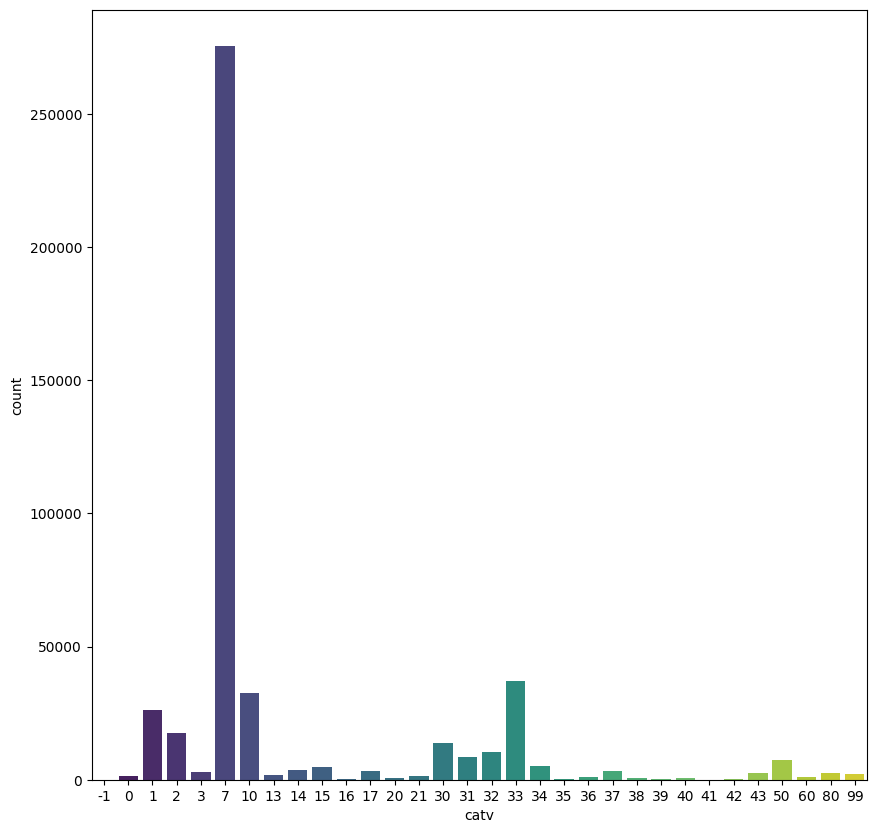

In [ ]:
#Pour la colonne Catégorie Véhicule , nous regardons la distribution par type de véhicule avant de procéder à un regroupement:
# la catégorie 7 est largement représentée( Véhicule Léger ), viennent ensuite les 2 roues (moto, scooter et bicyclette)

#Regroupement des catégories vehicules :
# 1 VL et V utilitaire
#2 Moto, scooter, 2 roues, 3 roues, quad
#3 Poids lourds
#4 Bus/car
#5 Velo/Vae/Edp et autres(trottinettes)

df_veh["catv"].value_counts()
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10,10))
sns.countplot(data=df_veh, x='catv',palette="viridis")


def replace_catv(catv):
  if catv in [7,10]:
    return 1
  if catv in [2,30,31,32,33,34,35,36,41,42,43]:
    return 2
  if catv in [13,14,15]:
    return 3
  if catv in [37,38]:
    return 4
  else:
    return 5


df_veh['new_catv'] = df_veh['catv'].apply(replace_catv)

df_veh=df_veh.drop("catv",axis=1)

<ipython-input-23-907a4ed06547>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_veh, x='new_catv',palette=palette)
<ipython-input-23-907a4ed06547>:2: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.countplot(data=df_veh, x='new_catv',palette=palette)


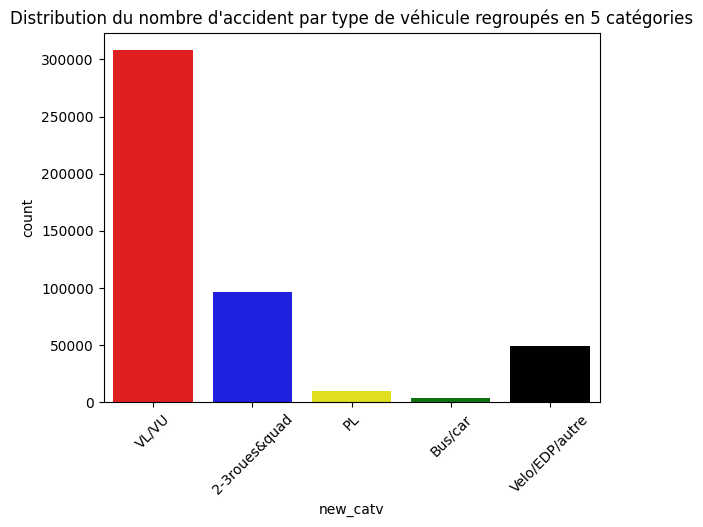

In [ ]:
palette=["red","blue","yellow","green","black","purple"]
sns.countplot(data=df_veh, x='new_catv',palette=palette)

plt.xticks(ticks=[0,1, 2, 3, 4], labels=["VL/VU", "2-3roues&quad", "PL", "Bus/car", "Velo/EDP/autre"],rotation=45);
plt.title("Distribution du nombre d'accident par type de véhicule regroupés en 5 catégories");

plt.show()

In [ ]:
#Pour la colonne CHOC , on choisit de regrouper de la manière suivante , après visualisation de la distribution
#0 pas de choc
# 1-2-3 Avant
#4-5-6 Arriere
#7-8 coté
#9 tonneaux

df_veh["choc"].value_counts()

,count
choc,
1,168558
3,69034
2,56911
4,46067
8,32530
0,29806
7,27660
6,16494
5,13299


In [ ]:
df_veh["aucun_choc"]=0
df_veh["choc_AV"]=0
df_veh["choc_AR"]=0
df_veh["choc_cote"]=0
df_veh["choc_tonneaux"]=0
def replace_choc(row):
  if row["choc"] in [1,2,3]:
    row["choc_AV"]+=1
  if row["choc"] in [4,5,6]:
    row["choc_AR"]+=1
  if row["choc"] in [7,8]:
    row["choc_cote"]+=1
  if row["choc"] in [9]:
    row["choc_tonneaux"]+=1
  if row["choc"] in [0]:
    row["aucun_choc"]+=1
  return row

df_veh = df_veh.apply(replace_choc, axis=1)

In [ ]:
# On filtre le df en conservant les variables qui nous intéressent uniquement
df_veh_filtre=df_veh[["Num_Acc","id_vehicule","new_catv","obstacle_fixe","obstacle_mobile","aucun_choc","choc_AV","choc_AR","choc_cote","choc_tonneaux"]]

In [ ]:
# On transforme la colonne nouvelle_cat_véhicule(new_catv) en 1 colonne par type de véhicule  et les renomme pour une meilleure lisibilité
df_veh1=pd.get_dummies(df_veh_filtre,columns=["new_catv"],dtype="int")
df_veh1=df_veh1.rename({"new_catv_1":"VL_VU","new_catv_2":"2roues_3roues_quad","new_catv_3":"PL","new_catv_4":"bus_car","new_catv_5":"velo_trott_edp","pieton_x":"catu_pieton","pieton_y":"place_pieton"},axis=1)

In [ ]:
# On rajoute une colonne qui comptabilise le nombre de véhicule

df_veh1["nbr_veh"]=0
nbr_veh_counts = df_veh1['id_vehicule'].value_counts().to_dict()
df_veh1['nbr_veh'] = df_veh1['id_vehicule'].map(nbr_veh_counts)
df_veh1

,Num_Acc,id_vehicule,obstacle_fixe,obstacle_mobile,aucun_choc,choc_AV,choc_AR,choc_cote,choc_tonneaux,VL_VU,2roues_3roues_quad,PL,bus_car,velo_trott_edp,nbr_veh
0,202100000001,201 764,0,1,0,1,0,0,0,0,0,0,0,1,1
1,202100000001,201 765,0,1,0,1,0,0,0,1,0,0,0,0,1
2,202100000002,201 762,1,1,0,1,0,0,0,1,0,0,0,0,1
3,202100000002,201 763,0,1,0,1,0,0,0,1,0,0,0,0,1
4,202100000003,201 761,0,1,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467164,201900058837,137 982 135,0,1,0,1,0,0,0,1,0,0,0,0,1
467165,201900058838,137 982 132,1,0,0,1,0,0,0,1,0,0,0,0,1
467166,201900058839,137 982 131,0,0,0,0,0,1,0,0,1,0,0,0,1
467167,201900058840,137 982 129,0,1,0,0,1,0,0,1,0,0,0,0,1


In [ ]:
#On merge le df_veh1 avec df usagers final (df_usag8)

df_merged_usag_veh=df_usag8.merge(df_veh1,on=["Num_Acc","id_vehicule"],how="left")

df_merged_usag_veh

,Num_Acc,id_vehicule,usager_count,grav_non_renseigné,indemne,tué,blessé_hospitalisé,blessé_léger,catu_conducteur,passager,...,choc_AV,choc_AR,choc_cote,choc_tonneaux,VL_VU,2roues_3roues_quad,PL,bus_car,velo_trott_edp,nbr_veh
0,201900000001,138 306 524,2,0,0,0,0,2,1,1,...,0,1,0,0,1,0,0,0,0,1
1,201900000001,138 306 525,1,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,1
2,201900000002,138 306 523,1,0,0,0,0,1,1,0,...,1,0,0,0,1,0,0,0,0,1
3,201900000003,138 306 520,2,0,1,0,0,1,1,1,...,1,0,0,0,1,0,0,0,0,1
4,201900000003,138 306 521,1,0,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463179,202300054820,155 583 348,2,0,0,0,0,2,1,1,...,0,1,0,0,1,0,0,0,0,1
463180,202300054821,155 583 346,1,0,0,0,0,1,1,0,...,1,0,0,0,0,1,0,0,0,1
463181,202300054821,155 583 347,1,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1
463182,202300054822,155 583 344,2,0,2,0,0,0,1,1,...,0,0,1,0,1,0,0,0,0,1


In [ ]:
# On utilise le groupby par numéro d'accident en utilisant la fonction "sum" , par exemple pour les lignes d'index 0 et 1 du df merged précédent qui correspondent au même accident, on regroupe à 1 ligne par accident en sommant les valeurs pour les autres colonnes (ex: usager_count devient 3)
# ainsi pour chaque colonne on connait le nombre de personnes concernées ( combien d'indemne, de tués, de passager, de piéton, de véhicule léger, de moto, etc, etc pour chaque accident )

df_merged_usag_veh_final=df_merged_usag_veh.groupby("Num_Acc").agg("sum").reset_in'dex()
df_merged_usag_veh_final.drop("id_vehicule",axis=1)

,Num_Acc,usager_count,grav_non_renseigné,indemne,tué,blessé_hospitalisé,blessé_léger,catu_conducteur,passager,pieton_x,...,choc_AV,choc_AR,choc_cote,choc_tonneaux,VL_VU,2roues_3roues_quad,PL,bus_car,velo_trott_edp,nbr_veh
0,201900000001,3,0,1,0,0,2,2,1,0,...,1,1,0,0,1,0,0,0,1,2
1,201900000002,1,0,0,0,0,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1
2,201900000003,4,0,2,0,0,2,3,1,0,...,1,2,0,0,3,0,0,0,0,3
3,201900000004,4,0,3,0,0,1,3,1,0,...,1,2,0,0,3,0,0,0,0,3
4,201900000005,3,0,2,0,0,1,2,1,0,...,0,2,0,0,2,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273221,202300054818,2,0,1,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
273222,202300054819,2,0,1,0,1,0,2,0,0,...,1,0,1,0,1,1,0,0,0,2
273223,202300054820,2,0,0,0,0,2,1,1,0,...,0,1,0,0,1,0,0,0,0,1
273224,202300054821,2,0,1,0,0,1,2,0,0,...,2,0,0,0,1,1,0,0,0,2


In [ ]:
df_merged_usag_veh_final

,Num_Acc,id_vehicule,usager_count,grav_non_renseigné,indemne,tué,blessé_hospitalisé,blessé_léger,catu_conducteur,passager,...,choc_AV,choc_AR,choc_cote,choc_tonneaux,VL_VU,2roues_3roues_quad,PL,bus_car,velo_trott_edp,nbr_veh
0,201900000001,138 306 524138 306 525,3,0,1,0,0,2,2,1,...,1,1,0,0,1,0,0,0,1,2
1,201900000002,138 306 523,1,0,0,0,0,1,1,0,...,1,0,0,0,1,0,0,0,0,1
2,201900000003,138 306 520138 306 521138 306 522,4,0,2,0,0,2,3,1,...,1,2,0,0,3,0,0,0,0,3
3,201900000004,138 306 517138 306 518138 306 519,4,0,3,0,0,1,3,1,...,1,2,0,0,3,0,0,0,0,3
4,201900000005,138 306 515138 306 516,3,0,2,0,0,1,2,1,...,0,2,0,0,2,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273221,202300054818,155 583 351,2,0,1,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,1
273222,202300054819,155 583 349155 583 350,2,0,1,0,1,0,2,0,...,1,0,1,0,1,1,0,0,0,2
273223,202300054820,155 583 348,2,0,0,0,0,2,1,1,...,0,1,0,0,1,0,0,0,0,1
273224,202300054821,155 583 346155 583 347,2,0,1,0,0,1,2,0,...,2,0,0,0,1,1,0,0,0,2


In [ ]:
#On enregistre df_merged_usag_veh final
df_merged_usag_veh_final.to_csv('/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/df_merged_usag_veh_final.csv', index=False)

A ce stade Vehicules et usagers sont mergés dans un df qui contient 273226 lignes
3. **La 3ème étape est de travailler la table Lieux**

In [ ]:
import pandas as pd
df_lieux=pd.read_csv("/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/all_data_lieux_2019_2023.csv")
df_lieux

<ipython-input-33-ab7a1dc83f93>:2: DtypeWarning: Columns (6,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lieux=pd.read_csv("/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/all_data_lieux_2019_2023.csv")


,Num_Acc,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,202000000001,4,HENRI BARBUSSE (AVENUE),0.0,NaN,2,2,0,1,0,0,1,NaN,-1,1,0,1,50
1,202000000002,4,MOUSSEAUX(CHEMIN),0.0,NaN,2,2,0,1,0,100,3,NaN,-1,1,0,1,50
2,202000000003,4,CARNOT(AVENUE),0.0,NaN,-1,2,0,1,0,0,1,NaN,-1,1,0,1,50
3,202000000004,4,VICTOR HUGO (AVENUE),0.0,NaN,2,2,0,1,1,0,1,NaN,-1,1,0,1,30
4,202000000005,3,35,0.0,NaN,1,1,0,1,4,674,2,NaN,-1,1,3,8,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289259,202200055298,3,71,-1.0,NaN,2,2,0,2,(1),(1),1,NaN,-1,1,0,8,80
289260,202200055299,3,973,-1.0,NaN,2,2,0,1,29,0,2,NaN,-1,1,0,3,80
289261,202200055300,3,22,0.0,D,2,2,0,1,39,553,2,NaN,-1,7,0,3,80
289262,202200055301,3,18,-1.0,D,2,2,0,1,30,125,1,NaN,-1,1,0,1,80


In [ ]:
# On constate dans un premier temps que le df_usag8 précédent, qui contient désormais 1 ligne par véhicule, compte 463184 lignes, alors que la table véhicule compte 467169 valeurs unique d'id_vehicules
print('nombre de valeurs id_vehicules uniques pour df_usag8',len(df_usag8["id_vehicule"].unique()))
print('nombre de valeurs id_vehicules uniques pour df_veh',len(df_veh["id_vehicule"].unique()))

nombre de valeurs id_vehicules uniques pour df_usag8 463184
nombre de valeurs id_vehicules uniques pour df_veh 467169


In [ ]:
# On crée 2 df pour me permettre de comparer et identifier les véhicules qui n'apparaissent pas dans la table usagers

id_veh=df_veh[["Num_Acc","id_vehicule"]]
id_veh
id_veh_usagers=df_usag8[["Num_Acc","id_vehicule"]]

id_veh_usagers["compare"]=1
id_veh_usagers
df_compare=id_veh.merge(id_veh_usagers,on=["Num_Acc","id_vehicule"],how="left")
df_compare.isna().sum()
id_diff=df_compare[df_compare["compare"].isna()]
print(id_diff)   # ce sont tous les numéros d'accidents pour lesquels ce numéro de véhicule n'est pas dans ma table usagers: 3985 lignes . On peut supposer que ce sont des véhicules pour lesquels il n'y a pas d'usagers ? par exemple des véhicules en stationnement ?

<ipython-input-35-14c842eeffaa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_veh_usagers["compare"]=1


             Num_Acc  id_vehicule  compare
16147   202100009430      184 842      NaN
39650   202100022987      160 540      NaN
69365   202100040202      129 739      NaN
70599   202100040933      128 454      NaN
76427   202100044328      122 431      NaN
...              ...          ...      ...
466942  201900058698  138 195 887      NaN
466979  201900058719  138 195 844      NaN
466982  201900058721  138 195 841      NaN
466993  201900058725  138 195 830      NaN
467132  201900058820  138 195 663      NaN

[3985 rows x 3 columns]


In [ ]:
df_lieux_filtre=df_lieux[["Num_Acc","catr","circ","nbv","vma","surf"]]

df_lieux_filtre

,Num_Acc,catr,circ,nbv,vma,surf
0,202000000001,4,2,2,50,1
1,202000000002,4,2,2,50,1
2,202000000003,4,-1,2,50,1
3,202000000004,4,2,2,30,1
4,202000000005,3,1,1,50,1
...,...,...,...,...,...,...
289259,202200055298,3,2,2,80,1
289260,202200055299,3,2,2,80,1
289261,202200055300,3,2,2,80,7
289262,202200055301,3,2,2,80,1


In [ ]:
df_lieux_filtre["catr"].value_counts()    # 4 représente route communale, 3 route départementale , 1 autoroute et 2 nationale

,count
catr,
4,124600
3,107864
1,25930
2,18046
7,8733
6,1976
9,1769
5,346


In [ ]:
#########CATR##########
#################### NEW CATR : on choisit de regrouper les nationales/dep/communales d'un côté, les autoroute de l'autre , les autres routes correspondent à – Hors réseau public – Parc de stationnement ouvert à la circulation publique – Routes de métropole urbaine
# 1 Autoroute
#2 nationale, departementale et communale 2,3,4
#3 Autre 5,6,7,9

df_lieux_filtre["autoroute"]=0
df_lieux_filtre["nationale_departementale_communale"]=0
df_lieux_filtre["autre_route"]=0
def replace_catr(row):
  if row["catr"] in [1]:
    row["autoroute"] +=1
  if row["catr"] in [2,3,4]:
    row["nationale_departementale_communale"] +=1
  if row["catr"] in [5,6,7,9]:
    row["autre_route"] +=1
  return row

df_lieux_filtre=df_lieux_filtre.apply(replace_catr,axis=1)


<ipython-input-38-c78ac1ee61e8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lieux_filtre["autoroute"]=0
<ipython-input-38-c78ac1ee61e8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lieux_filtre["nationale_departementale_communale"]=0
<ipython-input-38-c78ac1ee61e8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [ ]:
#Sens de circulation " CIRC"  qu'on regroupe en 2 modalités:

df_lieux_filtre["circ"].value_counts()

# 1 – A sens unique   (initialement modalité 1)
# 2 – Bidirectionnelle   (2 et autres)

,count
circ,
2,179267
1,52192
3,38803
-1,17205
4,1797


In [ ]:
df_lieux_filtre["sens_unique"]=0
df_lieux_filtre["bidirectionnel"]=0

def replace_circ(row):
  if row["circ"] in [1]:
    row["sens_unique"] +=1
  else:
    row["bidirectionnel"] +=1
  return row

df_lieux_filtre=df_lieux_filtre.apply(replace_circ,axis=1)


In [ ]:
#SURFACES

df_lieux["surf"].value_counts()  # 1 route normale, 2 route mouillée

# au vu de la distribution, on regroupe comme suit :
#1 normale
#2 mouillée/enneigee
#3 autre


# lorsqu'il y a 2 types de surfaces renseignés ( ce qui arrive notamment lorsque l'accident est survenu au niveau d'une intersection entre 2 routes, l'état de chacune des routes est parfois différent), on choisit de conserver l'état le plus accidentogène ( mouillé plutôt que normal)
# 272 valeurs non renseignées, on les gardes ainsi en les incluant dans "autres"


,count
surf,
1,232148
2,52688
9,1543
7,953
3,464
8,448
5,411
-1,272
6,219


In [ ]:
df_lieux_filtre["route_seche"]=0
df_lieux_filtre["route_mouillee_enneigee"]=0
df_lieux_filtre["etat_route_autre"]=0
def replace_surf(row):
  if row["surf"] in [1]:
    row["route_seche"] +=1
  if row["surf"] in [2,3,4,5]:
    row["route_mouillee_enneigee"] +=1
  if row["surf"] in [6,7,8,9]:
    row["etat_route_autre"]+=1
  return row

df_lieux_filtre=df_lieux_filtre.apply(replace_surf,axis=1)
df_lieux_filtre

,Num_Acc,catr,circ,nbv,vma,surf,autoroute,nationale_departementale_communale,autre_route,sens_unique,bidirectionnel,route_seche,route_mouillee_enneigee,etat_route_autre
0,202000000001,4,2,2,50,1,0,1,0,0,1,1,0,0
1,202000000002,4,2,2,50,1,0,1,0,0,1,1,0,0
2,202000000003,4,-1,2,50,1,0,1,0,0,1,1,0,0
3,202000000004,4,2,2,30,1,0,1,0,0,1,1,0,0
4,202000000005,3,1,1,50,1,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289259,202200055298,3,2,2,80,1,0,1,0,0,1,1,0,0
289260,202200055299,3,2,2,80,1,0,1,0,0,1,1,0,0
289261,202200055300,3,2,2,80,7,0,1,0,0,1,0,0,1
289262,202200055301,3,2,2,80,1,0,1,0,0,1,1,0,0


In [ ]:
## on fait ensuite un groupby par numéro d'accident , pour le nombre de voies(nbv), lorsqu'il y a 2 valeurs différentes ( dans le cas d'accidents survenue à une intersection ou un croisement par exemple), on conserve pour le moment le plus elevé, pour la VMA on choisit de conserver la plus élevée


df_lieux_final=df_lieux_filtre.groupby("Num_Acc").agg({"nbv":"max","vma":"max","nationale_departementale_communale":"sum","autoroute":"sum","autre_route":"sum","sens_unique":"sum","bidirectionnel":"sum","route_seche":"max","route_mouillee_enneigee":"max","etat_route_autre":"max"}).reset_index()

In [ ]:
# illustration des accidents où le Nombre de voies (nbv) est différents

grouped_df_nbv = df_lieux.groupby('Num_Acc')['nbv'].nunique().reset_index()    # 8570 accidents concernés
diff_nbv_groups = grouped_df_nbv[grouped_df_nbv['nbv'] > 1]['Num_Acc']

print(diff_nbv_groups)


# par ailleurs, on constate qu'il y a dans la table lieux initiale, 54 lignes pour lesquelles la colonne NBV est #valeurmulti, et 1 ligne où #ERREUR. On ne traite pas ces lignes qui sont en très faible nombre pour le moment, nous pourrons les remplacer si necessaire par la suite ou les laisser telles quel, ceci n'impactera pas notre modèle)
print(len(df_lieux.loc[df_lieux["nbv"]=="#VALEURMULTI"]))
print(len(df_lieux.loc[df_lieux["nbv"]=="#ERREUR"]))
print(df_lieux.value_counts("nbv"))

# Il y a également 4404 valeurs non renseignées, et des valeurs aberrantes (9, 10, 11, 12 voies, peu probable sur les routes francaises.


218404    202300000001
218408    202300000005
218411    202300000008
218412    202300000009
218415    202300000012
              ...     
273192    202300054789
273193    202300054790
273198    202300054795
273208    202300054805
273214    202300054811
Name: Num_Acc, Length: 8570, dtype: int64
54
1
nbv
2               116247
2                59578
4                22681
1                19643
3                14460
1                11184
4                 9284
3                 7273
6                 4978
0                 4761
 -1               4404
5                 3095
0                 2629
-1                1979
6                 1914
8                 1618
5                 1175
7                  623
8                  515
10                 432
9                  279
7                  138
12                  86
10                  83
11                  78
#VALEURMULTI        54
9                   40
12                  23
11                   9
#ERREUR              1
Name: 

In [ ]:
# illustration des accidents où la vitesse max (vma) est différente

grouped_df_vma = df_lieux.groupby('Num_Acc')['vma'].nunique().reset_index()    # 5169 accidents concernés
diff_vma_groups = grouped_df_vma[grouped_df_vma['vma'] > 1]['Num_Acc']

print(diff_vma_groups)
print(df_lieux_final["vma"].unique())   # il y a quelques valeurs aberrantes ( ex. 300 900 700 800)
print(df_lieux_final.loc[df_lieux_final["vma"]>130])  # ces valeurs aberrantes ( supérieures à 130 qui est la vitesse max autorisée, tout type de route confondu en France), représente 66 lignes
df_lieux_final.info()

218421    202300000018
218444    202300000041
218447    202300000044
218508    202300000105
218510    202300000107
              ...     
273150    202300054747
273160    202300054757
273197    202300054794
273202    202300054799
273214    202300054811
Name: Num_Acc, Length: 5169, dtype: int64
[ 70  90  30  50  80  60  10 110  20  -1 130  15   5  40   3   4   1   0
  45  25   2 500 100  65  12 120  35   6 560   7 700 800  42 600  55   8
 300 900 520 180  75 901   9 501 502 770 140  31  23]
             Num_Acc nbv  vma  nationale_departementale_communale  autoroute  \
4474    201900004475   2  500                                   1          0   
16899   201900016900   3  500                                   1          0   
18072   201900018073   1  500                                   1          0   
18413   201900018414   0  560                                   0          0   
21796   201900021797   4  500                                   1          0   
...              ...  .. 

In [ ]:
# Sauvegarde le df_lieux_final dans le drive partagé , il contient désormais 273226 lignes , 1 ligne par accident

df_lieux_final.to_csv('/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/df_lieux_final', index=False)

4. **La 4ème étape consiste à travailler la table caractéristiques qui contient déja 1 ligne par accident**


In [ ]:
# importation du df_caractéristiques
df_carac=pd.read_csv("/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/all_data_carac_2019_2023.csv")
df_carac

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,201900000001,30,11,2019,01:30,4,93,93053,1,1,1,2,AUTOROUTE A3,"48,8962100","2,4701200"
1,201900000002,30,11,2019,02:50,3,93,93066,1,1,1,6,AUTOROUTE A1,"48,9307000","2,3688000"
2,201900000003,28,11,2019,15:15,1,92,92036,1,1,1,4,AUTOROUTE A86,"48,9358718","2,3191744"
3,201900000004,30,11,2019,20:20,5,94,94069,1,1,1,4,A4,"48,8173295","2,4281502"
4,201900000005,30,11,2019,04:00,3,94,94028,1,1,1,2,A86 INT,"48,7763620","2,4332540"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273221,202300054818,26,10,2023,20:45,5,974,97416,2,1,1,6,LA FONTAINE (RUE JEAN DE),"-21,33828000","55,47771000"
273222,202300054819,26,10,2023,19:10,3,974,97416,1,1,1,3,RN3 (ANCIENNE ROUTE),"-21,28865000","55,50994000"
273223,202300054820,26,10,2023,09:40,1,974,97411,2,1,1,7,BAMBOU (CHEMIN DE LA RUELLE),"-20,90129000","55,40598000"
273224,202300054821,26,10,2023,17:20,1,973,97302,1,6,1,3,ROUTE NATIONALE 1,"4,89713000","-52,32854000"


In [ ]:
# Merge de la table lieux précédente avec la table caractéristiques
df_carac_lieux=df_carac.merge(df_lieux_final,on="Num_Acc",how="left")

In [ ]:
# Importation de la table précédemment mergée entre usagers et vehicules, puis merge des 2 tables afin d'obtenir le df_final complet et  agrégé à 1 ligne apr accident
df_merged_usag_veh_final=pd.read_csv("/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/df_merged_usag_veh_final.csv")
df_total_final=df_carac_lieux.merge(df_merged_usag_veh_final,on="Num_Acc",how="left")

In [ ]:
# On renomme quelques colonnes pour une meilleure compréhension

df_total_final=df_total_final.rename({"new_catv_1":"VL_VU","new_catv_2":"2roues_3roues","new_catv_3":"PL","new_catv_4":"bus_car","new_catv_5":"velo_trott_edp","pieton_x":"catu_pieton","pieton_y":"place_pieton"},axis=1)

In [ ]:
# Ajout d'une colonne qui determine la gravité de l'accident, nous décidons de conserver la gravité la + importante lorsque plusieurs usagers ont des gravités différentes ( par exemple si un accident compte un blessé leger et un tué, nous considérons cet accident comme mortel )

df_total_final["gravité_accident"]=0

#4 accident mortel
#3 accident avec blessés hospitalisés
#2 accident avec blessés legers
#1 accident avec des indemnes

def determine_gravite(row):
  if row["tué"]>0:
   return  4
  if row["tué"]==0 and row["blessé_hospitalisé"]>0:
    return 3
  if row["tué"]==0 and row["blessé_hospitalisé"]==0 and row["blessé_léger"]>0:
    return 2
  if row["tué"]==0 and row["blessé_hospitalisé"]==0 and row["blessé_léger"]==0 and row["indemne"]>0:
    return 1

df_total_final['gravité_accident'] = df_total_final.apply(determine_gravite, axis=1)

In [ ]:
# On supprime les colonnes inutiles pour notre étude (adr, com id_vehicule, lum)
# On supprime les colonnes redondantes (atu_conducteur, passager et catu_pieton sont redondantes avec la place de l'usager)
# On supprime les colonnes non renseignées, qui n'apportent aucune information (sexe non renseigné, total_secu_non_renseigné, total_secu-non_déterminé, grav_non_renseignée)
# ON exclut les outliers de la variable age (>96)
df_total_final=df_total_final.drop(["adr","com","id_vehicule","lum", "catu_pieton", "catu_conducteur", "passager", "sex_non_renseigné", "total_secu_non_renseigné", 'total_non_deter', "grav_non_renseigné",">96"],axis=1)

In [ ]:
df_total_final

,Num_Acc,jour,mois,an,hrmn,dep,agg,int,atm,col,...,choc_AR,choc_cote,choc_tonneaux,VL_VU,2roues_3roues_quad,PL,bus_car,velo_trott_edp,nbr_veh,gravité_accident
0,201900000001,30,11,2019,01:30,93,1,1,1,2,...,1,0,0,1,0,0,0,1,2,2
1,201900000002,30,11,2019,02:50,93,1,1,1,6,...,0,0,0,1,0,0,0,0,1,2
2,201900000003,28,11,2019,15:15,92,1,1,1,4,...,2,0,0,3,0,0,0,0,3,2
3,201900000004,30,11,2019,20:20,94,1,1,1,4,...,2,0,0,3,0,0,0,0,3,2
4,201900000005,30,11,2019,04:00,94,1,1,1,2,...,2,0,0,2,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273221,202300054818,26,10,2023,20:45,974,2,1,1,6,...,0,1,0,1,0,0,0,0,1,2
273222,202300054819,26,10,2023,19:10,974,1,1,1,3,...,0,1,0,1,1,0,0,0,2,3
273223,202300054820,26,10,2023,09:40,974,2,1,1,7,...,1,0,0,1,0,0,0,0,1,2
273224,202300054821,26,10,2023,17:20,973,1,6,1,3,...,0,0,0,1,1,0,0,0,2,2


In [ ]:
# On enregistre le df_total_final dans le drive partagé
df_total_final.to_csv('/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/df_total_final.csv', index=False)

Maintenant que nous avons notre DataFrame d'étude, nous allons réaliser une analyse exploratoire des différentes variables explicatives, étudier et statuer sur les outliers, les valeurs manquantes,  et étudier l'impact des variables explicatives sur la variable cible. Puis nous préparerons les données pour les soumettre à différents modèles de machine learning.

1. Analyse exploratoire

  a. Conditions et gravité


  b. Usagers et gravité

c. Localisation et gravité

  d. Véhicules et gravité

2. Prédiction de la gravité

In [ ]:
from google.colab import drive
import pandas as pd
import os
from io import StringIO
# Monter Google Drive
drive.mount('/content/drive', force_remount= True) #force_remount = True permet d'avoir un fichier mis à jour si modifs sur google drive

import pandas as pd
df_total_final=pd.read_csv("/content/drive/MyDrive/Projet_accidents/Dataset/2019_2023/df_total_final.csv")
df_total_final.info()
df = df_total_final.copy()

Mounted at /content/drive


<ipython-input-3-3fb84b0cf0b3>:9: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_total_final=pd.read_csv("/content/drive/MyDrive/Projet_accidents/Dataset/2019_2023/df_total_final.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273226 entries, 0 to 273225
Data columns (total 60 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Num_Acc                             273226 non-null  int64 
 1   jour                                273226 non-null  int64 
 2   mois                                273226 non-null  int64 
 3   an                                  273226 non-null  int64 
 4   hrmn                                273226 non-null  object
 5   dep                                 273226 non-null  object
 6   agg                                 273226 non-null  int64 
 7   int                                 273226 non-null  int64 
 8   atm                                 273226 non-null  int64 
 9   col                                 273226 non-null  int64 
 10  lat                                 273226 non-null  object
 11  long                                273

Modifications du df et premières analyses par des graphiques


In [ ]:
# Importation des librairies nécessaires pour les graphiques
import plotly as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
# Transformation de la date en format datetime
df['date']= pd.to_datetime(df['jour'].astype('str')+'/'+df['mois'].astype('str')+'/'+df['an'].astype('str')+ '/'+df['hrmn'].astype('str'), dayfirst = True)


In [ ]:
# Nombre d'accidents par gravité

gravité = df.groupby('gravité_accident').size().reset_index(name='nombre_accidents')
print(gravité)
fig = px.bar(gravité, x='gravité_accident', y = 'nombre_accidents',title="Répartition de la gravité", color = 'gravité_accident')
fig.update_xaxes(tickmode='array', tickvals=[2,3,4],ticktext=['blessé_léger', 'blessé_grave', 'tué'])
fig.show();


# On constate que la modalité gravité 1 n'apparait pas, ce qui signifierait qu'il n'y a aucun accident avec uniquement des indemnes.
# On fait quelques vérifications pour s'assurer qu'il ne s'agit pas d'une erreur de codage lors de la requalification de la gravité de l'accident, on extraie les lignes pour lesquelles il y a une valeur dans indemne mais aucune dans tué, hospitalisé et blessé léger, en effet on constate 0 lignes,
df.loc[(df["indemne"]>1)&(df["blessé_léger"]==0)&(df["blessé_hospitalisé"]==0)&(df["tué"]==0)]

   gravité_accident  nombre_accidents
0                 2            175525
1                 3             82229
2                 4             15472


,Num_Acc,jour,mois,an,hrmn,dep,agg,int,atm,col,...,choc_cote,choc_tonneaux,VL_VU,2roues_3roues_quad,PL,bus_car,velo_trott_edp,nbr_veh,gravité_accident,date


On constate un déséquilibre de la répartition des valeurs de la variable cible (gravité de l'accident), qu'il faudra garder en tête pour nos modèles
 de machine learning.

In [ ]:
# On revérifie depuis la table usagers initiale qu'il n'y a aucun accident sans aucun blessé: en effet il n' y a aucun accident avec uniquement des indemnes. Une hypothèse serait que les accidents ne sont référencés dans cette base de données que dès lors qu'il y a au moins 1 usager blessé léger?

gpby_grav=df_usag.groupby("Num_Acc")["grav"].max()
gpby_grav.value_counts()   # aucun accident avec la valeur 1 ( indemne)

,count
grav,
4,193090
3,69307
2,10829


a. Conditions de l'accident

Date

In [ ]:
fig = make_subplots(rows=2, cols=2, subplot_titles=("Nombre d'accidents par année",  "Nombre d'accidents par jour de la semaine", "Nombre d'accidents par mois","Nombre d'accidents par heure"))
accidents_par_an = df.groupby([df['date'].dt.year,'gravité_accident']).size().reset_index(name='nombre_accidents_an')
accidents_par_an['date'] = accidents_par_an['date'].astype(str)
print(accidents_par_an)
bar1 = px.bar(accidents_par_an, y='nombre_accidents_an', x='date', color = 'gravité_accident', barmode = 'group',labels={"gravité_accident": "Gravité de l'accident", "nombre_accidents_an": "Nombre d'accidents"},  # Labels personnalisés
    title="Nombre d'accidents par gravité et par année",)
for trace in bar1.data:
    fig.add_trace(trace, row=1, col=1)
    fig.update_xaxes(tickmode='array', tickvals=[2019, 2020, 2021, 2022,2023],ticktext=['2019', '2020', '2021', '2022','2023'], row=1, col=1)


accidents_par_mois = df.groupby([df['date'].dt.month, 'gravité_accident']).size().reset_index(name='nombre_accidents_mois')
bar2 = px.bar(accidents_par_mois, x='date', y='nombre_accidents_mois',color = 'gravité_accident')
for trace in bar2.data:
    fig.add_trace(trace, row=2, col=1)
    fig.update_xaxes(tickmode='array', tickvals=[1,2,3,4,5,6,7,8,9,10,11,12],  # Exemple: vos années
    ticktext=['janvier','fevrier', 'mars', 'avril', 'mai', 'juin', 'juillet', 'aout', 'septembre', 'octobre', 'novembre', 'décembre'], row=2, col=1)



accidents_par_jour = df.groupby([df['date'].dt.weekday, 'gravité_accident']).size().reset_index(name='nombre_accidents_jour')
bar3 = px.bar(accidents_par_jour, x='date', y='nombre_accidents_jour',color = 'gravité_accident')
for trace in bar3.data:
    fig.add_trace(trace, row=1, col=2)
    fig.update_xaxes(tickmode='array', tickvals=[0,1,2,3,4,5,6],ticktext = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'], row=1, col=2)

accidents_par_heure = df.groupby([df['date'].dt.hour, 'gravité_accident']).size().reset_index(name='nombre_accidents_heure')
bar4 = px.bar(accidents_par_heure, x='date', y='nombre_accidents_heure',color = 'gravité_accident')
for trace in bar4.data:
    fig.add_trace(trace, row=2, col=2)
    fig.update_xaxes(tickmode='array', tickvals=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],ticktext =  ['0', '1','2','3','4','5','6','7','8', '9', '10','11','12','13','14','15','16','17','18', '19', '20', '21', '22','23'], row=2, col=2)

fig.update_layout(title="Répartition des accidents par année, mois et jour de la semaine", showlegend=False,barmode = 'group', hovermode='y')
fig.show();


    date  gravité_accident  nombre_accidents_an
0   2019                 2                37619
1   2019                 3                17937
2   2019                 4                 3284
3   2020                 2                30513
4   2020                 3                14615
5   2020                 4                 2616
6   2021                 2                36965
7   2021                 3                16521
8   2021                 4                 3032
9   2022                 2                35391
10  2022                 3                16574
11  2022                 4                 3337
12  2023                 2                35037
13  2023                 3                16582
14  2023                 4                 3203


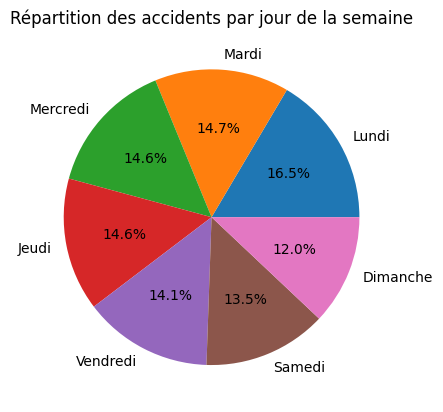

<Axes: xlabel='an', ylabel='count'>

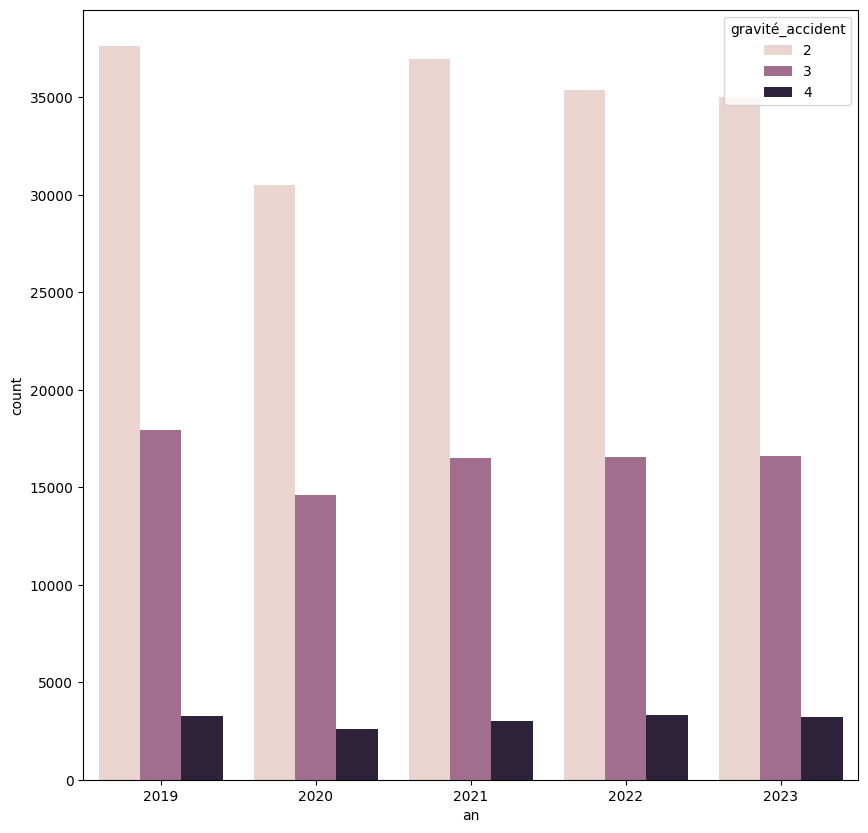

In [ ]:
import matplotlib.pyplot as plt
df["jour_semaine"]=df["date"].dt.weekday
plt.pie(df["jour_semaine"].value_counts(), labels=["Lundi","Mardi","Mercredi","Jeudi","Vendredi","Samedi","Dimanche"],autopct="%1.1f%%")
plt.title("Répartition des accidents par jour de la semaine")
plt.show()


#Distribution du nombre d'accident par gravité par année
import seaborn as sns
plt.figure(figsize=(10,10))
grav_par_an=df.groupby(["an","gravité_accident"]).size().reset_index(name="count")
grav_par_an
sns.barplot(data=grav_par_an,y="count",x="an",hue="gravité_accident")

Le nombre d'accidents par an est à peu près stable, sauf l'année 2020 qui est l'année du covid. Il y a plus d'accidents en juin, juillet, septembre, octobre, et le vendredi, et entre 17 et 18h.

In [ ]:
#Evolution du nombre de blessés graves, légers et tués par année
df_grav = df.groupby(df['date']).agg({'blessé_léger': 'sum', 'blessé_hospitalisé': 'sum', 'tué': 'sum'}).reset_index()
df_grav

,date,blessé_léger,blessé_hospitalisé,tué
0,2019-01-01 00:10:00,0,0,1
1,2019-01-01 00:20:00,0,2,0
2,2019-01-01 00:30:00,0,2,1
3,2019-01-01 00:40:00,0,1,0
4,2019-01-01 01:11:00,0,1,0
...,...,...,...,...
203103,2023-12-31 22:50:00,1,0,0
203104,2023-12-31 23:10:00,1,1,0
203105,2023-12-31 23:15:00,1,0,0
203106,2023-12-31 23:25:00,0,2,0


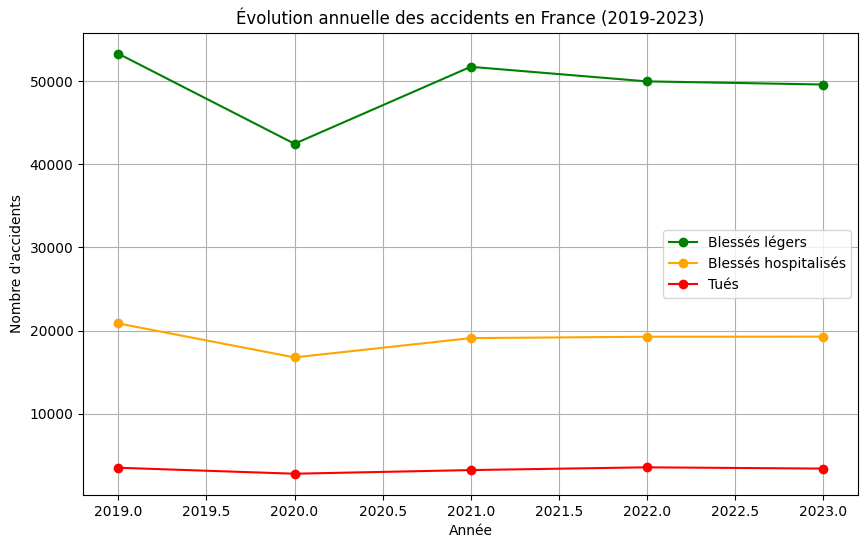

In [ ]:
df_nb_grav = df.groupby(df['date'].dt.year).agg({'blessé_léger': 'sum', 'blessé_hospitalisé': 'sum', 'tué': 'sum'}).reset_index()
df_nb_grav

# Tracer l'évolution annuelle pour chaque catégorie
plt.figure(figsize=(10, 6))

# Tracer chaque catégorie avec une ligne différente
plt.plot(df_nb_grav['date'], df_nb_grav['blessé_léger'], marker='o', label="Blessés légers", color='green')
plt.plot(df_nb_grav['date'], df_nb_grav['blessé_hospitalisé'], marker='o', label="Blessés hospitalisés", color='orange')
plt.plot(df_nb_grav['date'], df_nb_grav['tué'], marker='o', label="Tués", color='red')

# Ajouter un titre et des labels
plt.title("Évolution annuelle des accidents en France (2019-2023)")
plt.xlabel("Année")
plt.ylabel("Nombre d'accidents")
plt.grid(True)

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()

La répartition blessés légers, blessés hospitalisés et tués est globalement constante dans le temps (sauf en 2019, année covid). Mais nous avons pu constater des variations selon les mois, et selon les jours de la semaine. Nous gardons cela en tête pour éventuellement analyser la série temporelle et prédire les nombres de blessés légers, hospitalisés, et graves en fonction des données du passé, par département par exemple. Cela permet d'ajuster en avance les moyens humains et matériels. Nous effectuerons ce travail dans la deuxième partie (prédiction de la gravité).

In [ ]:
from scipy.stats import chi2_contingency
contingence = pd.crosstab(df['date'].dt.weekday, df['gravité_accident'])

# Appliquer le test du Chi-carré
chi2, p_value, dof, expected = chi2_contingency(contingence)

# Interprétation
if p_value < 0.05:
    print("Le jour de la semaine influence significativement la gravité de l'accident (p < 0.05).")
else:
    print("Aucune influence significative du jour de la semaine sur la gravité de l'accident.")

Le jour de la semaine influence significativement la gravité de l'accident (p < 0.05).


In [ ]:
from scipy.stats import chi2_contingency
contingence = pd.crosstab(df['date'].dt.year, df['gravité_accident'])

# Appliquer le test du Chi-carré
chi2, p_value, dof, expected = chi2_contingency(contingence)

# Interprétation
if p_value < 0.05:
    print("L'année influence significativement la gravité de l'accident (p < 0.05).")
else:
    print("Aucune influence significative de l'année sur la gravité de l'accident.")

L'année influence significativement la gravité de l'accident (p < 0.05).


In [ ]:
from scipy.stats import chi2_contingency
contingence = pd.crosstab(df['date'].dt.hour, df['gravité_accident'])

# Appliquer le test du Chi-carré
chi2, p_value, dof, expected = chi2_contingency(contingence)

# Interprétation
if p_value < 0.05:
    print("L'heure influence significativement la gravité de l'accident (p < 0.05).")
else:
    print("Aucune influence significative de l'heure sur la gravité de l'accident.")

L'heure influence significativement la gravité de l'accident (p < 0.05).


Vitesse maximale autorisée

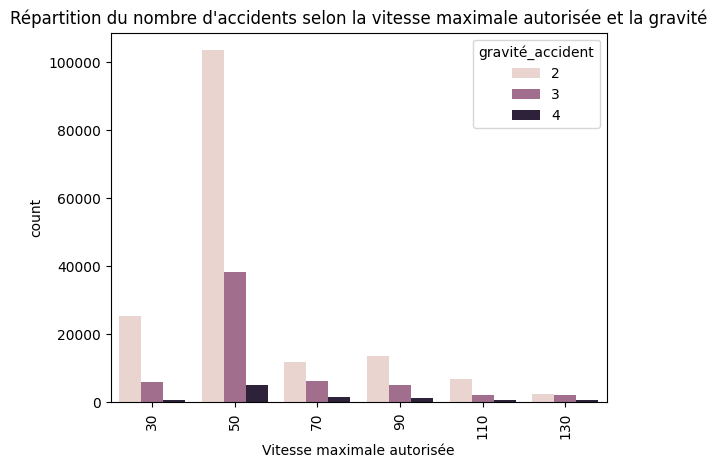

vma
100        39
20        760
60        771
130      5203
110      9700
70      19517
90      19976
30      31813
80      38905
50     146542
Name: count, dtype: int64


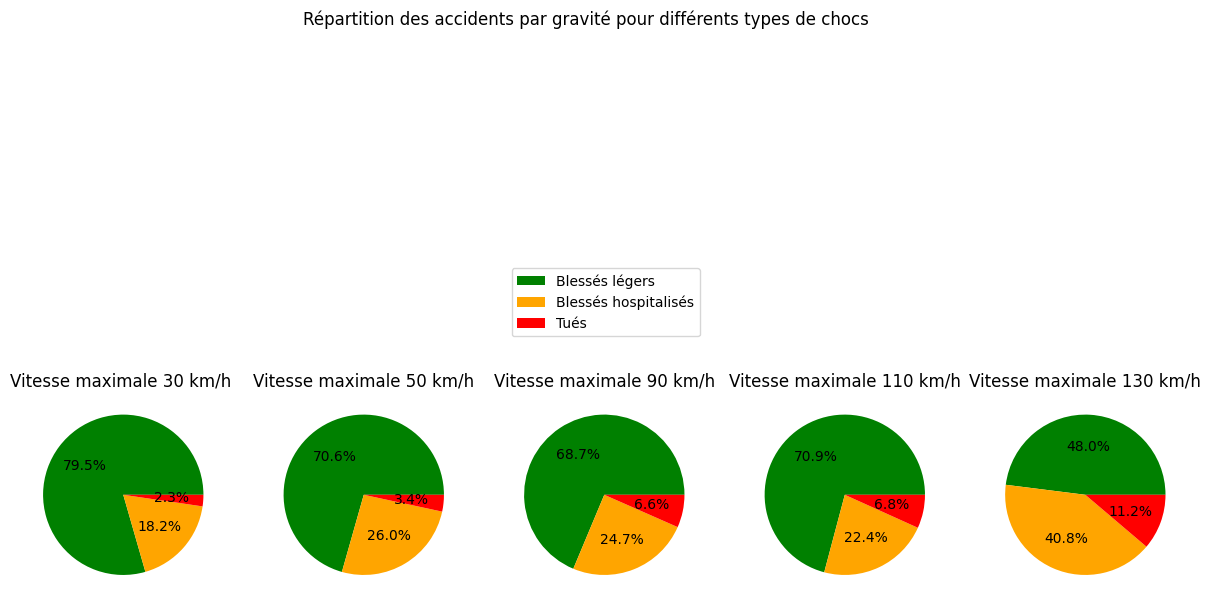

In [ ]:
# On supprime les vitesses qui sont mal renseignées (0, 500...)
df_filtered = df[df['vma'].isin([30, 50, 70, 90, 110, 130])]

sns.countplot(x = 'vma', hue = 'gravité_accident', data = df_filtered)
plt.title("Répartition du nombre d'accidents selon la vitesse maximale autorisée et la gravité")
plt.xticks(rotation = 90)
plt.xlabel('Vitesse maximale autorisée')
plt.show();

# Repartition de la gravité de l'accident pour chaque vitesse maximale autorisée
vitesse_30 = df_filtered[df_filtered['vma']==30].groupby('gravité_accident').size()
vitesse_50 = df_filtered[df_filtered['vma']==50].groupby('gravité_accident').size()
vitesse_70 = df_filtered[df_filtered['vma']==70].groupby('gravité_accident').size()
vitesse_90 = df_filtered[df_filtered['vma']==90].groupby('gravité_accident').size()
vitesse_110 = df_filtered[df_filtered['vma']==110].groupby('gravité_accident').size()
vitesse_130 = df_filtered[df_filtered['vma']==130].groupby('gravité_accident').size()

labels = ['Blessés légers', 'Blessés hospitalisés', 'Tués']
fig,axs=plt.subplots(1,5,figsize=(15,10))

axs[0].pie(vitesse_30,colors=["green","orange","red"],autopct="%1.1f%%")
axs[0].set_title("Vitesse maximale 30 km/h ")
axs[1].pie(vitesse_50,colors=["green","orange","red"],autopct="%1.1f%%")
axs[1].set_title("Vitesse maximale 50 km/h")
axs[2].pie(vitesse_90,colors=["green","orange","red"],autopct="%1.1f%%")
axs[2].set_title("Vitesse maximale 90 km/h")
axs[3].pie(vitesse_110,colors=["green","orange","red"],autopct="%1.1f%%")
axs[3].set_title("Vitesse maximale 110 km/h")
axs[4].pie(vitesse_130,colors=["green","orange","red"],autopct="%1.1f%%")
axs[4].set_title("Vitesse maximale 130 km/h")


fig.suptitle("Répartition des accidents par gravité pour différents types de chocs")
fig.legend(labels, loc='center')


# On décide de remplacer les vitesses mal renseignées par le mode de la vma
print(df['vma'].value_counts(ascending = True))
df['vma']=df['vma'].replace([-1,1,2,31,45,5,15,25,10,40,500,6,35,3,300,900,4,65,700,75,7,12,55,8,0,180,140,770,502,501,9,901,520,600,42,800,560,120,23], df['vma'].mode()[0])

Il y a beaucoup plus d'accidents sur les routes limitées à 50 km/h. Les accidents les plus graves sont sur les routes à 130 km/h

b. Usagers

Variable Sexe

,gravité_accident,homme,femme
0,2,266089,130420
1,3,126096,54468
2,4,25700,8961


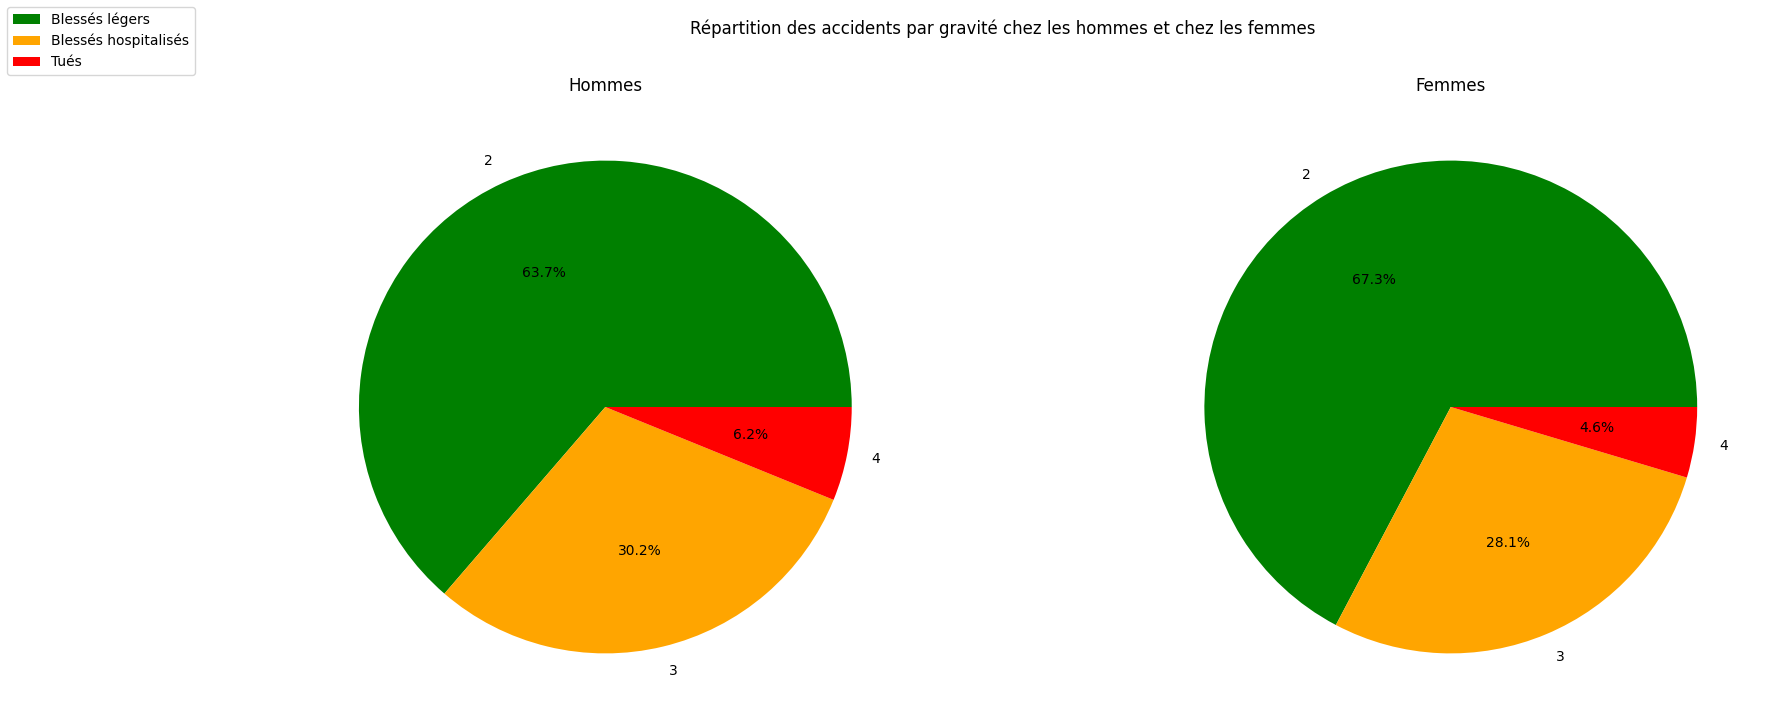

In [ ]:

sex = df.groupby('gravité_accident').agg({'homme':'sum', 'femme': 'sum'}).reset_index()
display(sex)
fig = px.bar(sex, x='gravité_accident', y=['homme','femme'], title="Gravité selon le sexe", barmode='group')
fig.update_xaxes(tickmode='array', tickvals=[2,3,4],ticktext=['blessé_léger', 'blessé_grave', 'tué'])
fig.show();

grav_homme = sex[['gravité_accident', 'homme']]
grav_femme = sex[['gravité_accident','femme']]


labels = ['Blessés légers', 'Blessés hospitalisés', 'Tués']
fig,axs=plt.subplots(1,2,figsize=(20,8))

axs[0].pie(grav_homme['homme'], labels = grav_homme['gravité_accident'],colors=["green","orange","red"],autopct="%1.1f%%")
axs[0].set_title("Hommes")

axs[1].pie(grav_femme['femme'],labels = grav_femme['gravité_accident'], colors=["green","orange","red"],autopct="%1.1f%%")
axs[1].set_title("Femmes")


fig.suptitle("Répartition des accidents par gravité chez les hommes et chez les femmes")
fig.legend(labels, loc='upper left')


Les hommes ont plus d'accidents que les femmes, et la proportion d'accidents mortels ou graves chez les hommes est aussi plus élevée que chez les femmes. La variable sexe semble influencer la gravité de l'accident.

Age

,gravité_accident,0-17,18-60,61-95
0,2,35320,302749,46900
1,3,17721,124179,32162
2,4,2506,23374,7631


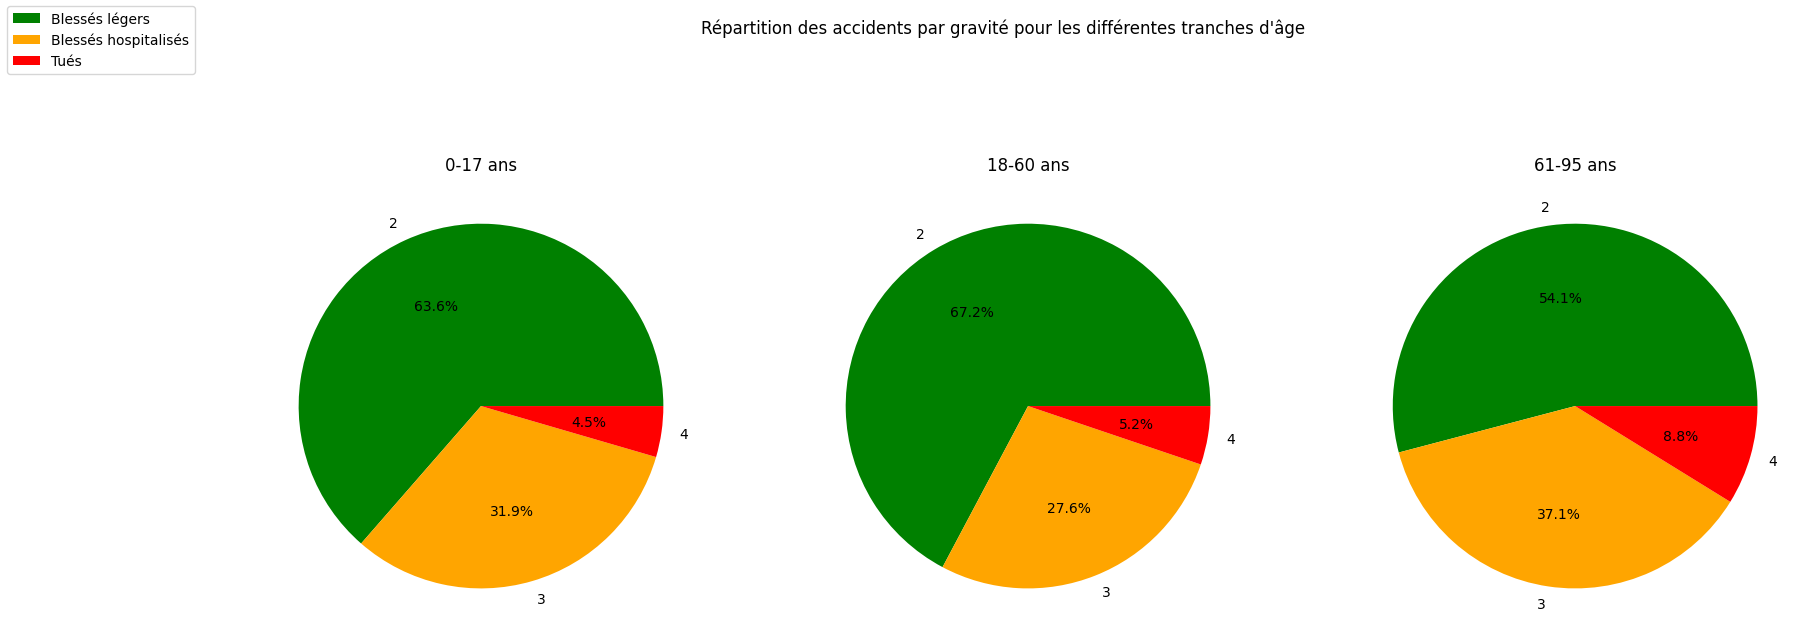

In [ ]:
age = df.groupby('gravité_accident').agg({'0-17': 'sum', '18-60':'sum', '61-95':'sum'}).reset_index()
display(age)
fig = px.bar(age, x='gravité_accident', y=['0-17','18-60','61-95'], title="Répartition du nombre d'usagers par classe d'âge et par gravité", barmode='group')
fig.update_xaxes(tickmode='array', tickvals=[2,3,4],ticktext=['blessé_léger', 'blessé_grave', 'tué'])
fig.show();

grav_0_17 = age[['gravité_accident','0-17']]
grav_18_60 = age[['gravité_accident','18-60']]
grav_61_95 = age[['gravité_accident','61-95']]


labels = ['Blessés légers', 'Blessés hospitalisés', 'Tués']
fig,axs=plt.subplots(1,3,figsize=(20,8))

axs[0].pie(grav_0_17['0-17'], labels = grav_0_17['gravité_accident'],colors=["green","orange","red"],autopct="%1.1f%%")
axs[0].set_title("0-17 ans")

axs[1].pie(grav_18_60['18-60'],labels = grav_18_60['gravité_accident'], colors=["green","orange","red"],autopct="%1.1f%%")
axs[1].set_title("18-60 ans")

axs[2].pie(grav_61_95['61-95'],labels = grav_61_95['gravité_accident'], colors=["green","orange","red"],autopct="%1.1f%%")
axs[2].set_title("61-95 ans")


fig.suptitle("Répartition des accidents par gravité pour les différentes tranches d'âge")
fig.legend(labels, loc='upper left')


IL y a évidemment beaucoup plus de 18_60 ans impliqués dans les accidents puisque la tranche d'âge est plus large. On constate que la proportion d'accidents graves (tués et blessés hospitalisés) est plus élevée chez les 61-96 ans. L'age semble donc impacter la gravité de l'accident.

Variable système de sécurité

In [ ]:
grav = df.groupby('gravité_accident').agg({'total_sans_secu':'sum', 'total_ceinture': 'sum', 'total_casque': 'sum', 'total_secu_enfant':'sum', 'total_gilet':'sum', 'total_airbag':'sum', 'total_gants': 'sum', 'total_gants_airbag':'sum', 'total_autre': 'sum'}).reset_index()
display(grav)
fig = px.bar(grav, x='gravité_accident', y=[ 'total_sans_secu', 'total_ceinture', 'total_casque', 'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants', 'total_gants_airbag', 'total_autre'], title="Répartition du nombre d'usagers par catégorie de système de sécurité selon la gravité", barmode='group')
fig.update_xaxes(tickmode='array', tickvals=[2,3,4],ticktext=['blessé_léger', 'blessé_grave', 'tué'])
fig.show();


,gravité_accident,total_sans_secu,total_ceinture,total_casque,total_secu_enfant,total_gilet,total_airbag,total_gants,total_gants_airbag,total_autre
0,2,222798,245425,70921,2890,5625,4684,35104,525,2038
1,3,55705,101901,38598,1423,1041,2131,20112,267,4378
2,4,11158,19486,4804,324,198,411,2438,36,762


On constate que l'équipement de sécurité majoritaire est le port de ceinture, et que l'absence de ceinture arrive en seconde position, quelle que soit la gravité de l'accident.

c. Localisation de l'accident

Carte de la répartition géographique des accidents

['93' '92' '94' '87' '69' '38' '34' '13' '988' '976' '974' '972' '2B' '91'
 '86' '83' '80' '78' '77' '76' '72' '71' '67' '66' '64' '60' '51' '50'
 '49' '45' '37' '35' '33' '31' '30' '29' '22' '19' '18' '17' '74' '81' '2'
 '59' '95' '63' '62' '973' '2A' '84' '9' '73' '43' '10' '36' '16' '7' '21'
 '40' '24' '4' '85' '27' '28' '52' '68' '42' '82' '11' '987' '44' '61'
 '14' '56' '58' '54' '47' '41' '3' '75' '1' '57' '32' '39' '15' '23' '6'
 '5' '26' '48' '986' '971' '89' '25' '12' '88' '65' '53' '70' '46' '90'
 '8' '79' '977' '55' '978' '975' '06' '03' '07' '01' '08' '02' '05' '04'
 '09']


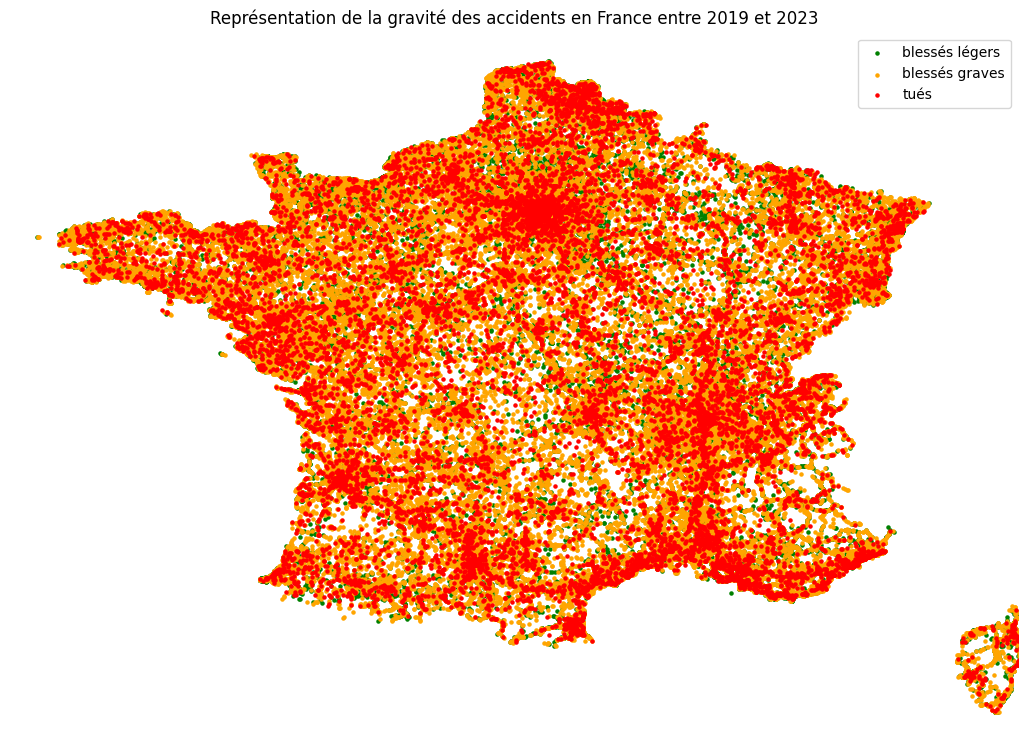

In [ ]:
import geopandas as gpd
from shapely.geometry import Point


# Affhichage des coordonnées de chaque accident, et transformation de 'lat', 'long' et 'dep' en type int.
df['lat']= df['lat'].astype('str').apply(lambda x: x.replace('\t', '.').replace(',', '.'))
df['lat'] = df['lat'].astype('float').round(5)
df['long']= df['long'].astype('str').apply(lambda x: x.replace('\t', '.').replace(',', '.'))
df['long'] = df['long'].astype('float').round(5) #avec 5 décimales, précision de 1m

# Lignes dont les départements sont numériques
df_dep_num= df.loc[df['dep'].astype('str').apply(lambda x: x.isnumeric())].astype('str')


# Lignes pour lesquelles le dep est la corse
df_dep_corse = df.loc[df['dep'].astype('str').apply(lambda x: x.isnumeric()== False)].astype('str')



# Sélectionner les accidents dans les départements dont le code est inférieur à 900, c'est à dire ceux en métropole
df_m = df[(df['dep'].isin(df_dep_num.dep.unique())) | (df['dep'].isin(df_dep_corse.dep.unique()))]

print(df_m['dep'].unique())
# Supprimer les accidents avec des coordonnées de latitude et de longitude nulles ou manquantes
df_m = df_m[(df_m['lat'] != 0.0) & (df_m['long'] != 0.0)].dropna(subset = ['lat', 'long'], axis = 0)


# Créer une géométrie Point pour chaque paire de coordonnées (longitude, latitude)
geometry = [Point(xy) for xy in zip(df_m['long'], df_m['lat'])]

# Créer un GeoDataFrame à partir des données d'accidents et de la géométrie Point
geo_df = gpd.GeoDataFrame(df_m, geometry=geometry)

# Créer une figure et des axes pour la carte
figure, ax = plt.subplots(figsize = (13, 12))

# Masquer les axes pour une apparence plus propre
plt.axis('off')

# Définir les limites des axes pour inclure toute la France
ax.set_xlim([-5.5, 9.5])  # Longitude (Ouest-Est)
ax.set_ylim([41.0, 51.5])  # Latitude (Sud-Nord)

# Tracer les accidents sur la carte en utilisant différentes couleurs pour chaque gravité
geo_df[geo_df['gravité_accident'] == 2].plot(ax = ax, markersize = 5, color = 'green', label = 'blessés légers')
geo_df[geo_df['gravité_accident'] == 3].plot(ax = ax, markersize = 5, color = 'orange', label = 'blessés graves')
geo_df[geo_df['gravité_accident'] == 4].plot(ax = ax, markersize = 5, color = 'red', label = 'tués')
plt.title('Représentation de la gravité des accidents en France entre 2019 et 2023')
plt.legend()

L'Ile de France regroupe le plus d'accidents mortels. La région PACA et Lyon ont également beaucoup de blessés graves et du tués. On constate une plus forte concentration d'accidents dans les villes.

Localisation: agglomération ou hors agglomération


Il y a beaucoup plus d'accidents en agglomération qu'hors agglomération, ce que l'on avait déjà noté sur la carte géographique.
Les accidents sont plus graves en dehors des agglomérations.
On peut faire l'hypothèse que la localisation(agglo/hors agglo) influence la gravité de l'accident. Vérifions par un test statistique

agg                   1      2
gravité_accident              
2                 17.42  46.82
3                 14.96  15.14
4                  3.76   1.90
la statistique du test est 6.914831853909753
la-pvalue du test est 0.031511083844732016
0.0
La localisation (agglo/hors agglo) influence significativement la gravité de l'accident (p < 0.05).


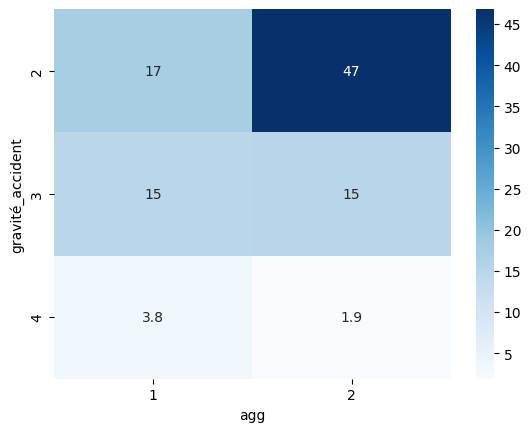

In [ ]:
contingence_agg = pd.crosstab(df['gravité_accident'], df['agg'],normalize = True)
contingence_agg = pd.DataFrame(contingence_agg).apply(lambda x: round(x, 4)*100, axis = 1)
print(contingence_agg)

# Créer la heatmap avec Plotly Express
sns.heatmap(contingence_agg, annot=True, cmap='Blues')


results = chi2_contingency(contingence_agg)
print ('la statistique du test est', results[0])
print ('la-pvalue du test est', results[1])
# Appliquer le test du Chi-carré

print(p_value)
# Interprétation:

if p_value < 0.05:
    print("La localisation (agglo/hors agglo) influence significativement la gravité de l'accident (p < 0.05).")
else:
    print("Aucune influence significative de la localisation (agglo/hors agglo) sur la gravité de l'accident.")


d. Véhicules

Etude de la variable 'Categorie véhicule'

proportion des gravités d'accidents impliquant au moins 1 PL gravité_accident
2    0.562666
3    0.302558
4    0.134777
dtype: float64
proportion des gravités d'accidents impliquant au moins 1 2roues ou 3 roues ou quad  gravité_accident
2    0.613414
3    0.343610
4    0.042977
dtype: float64
proportion des gravités d'accidents impliquant au moins 1 bus ou car  gravité_accident
2    0.715844
3    0.223377
4    0.060779
dtype: float64
proportion des gravités d'accidents impliquant au moins 1 VL VU gravité_accident
2    0.655682
3    0.290699
4    0.053618
dtype: float64
proportion des gravités d'accidents impliquant au moins 1 engin de déplacement personnel (velo, trott ou edp) gravité_accident
2    0.693606
3    0.255172
4    0.051222
dtype: float64
proportion des gravités d'accidents impliquant au moins 1 piéton gravité_accident
2    0.650899
3    0.294326
4    0.054775
dtype: float64


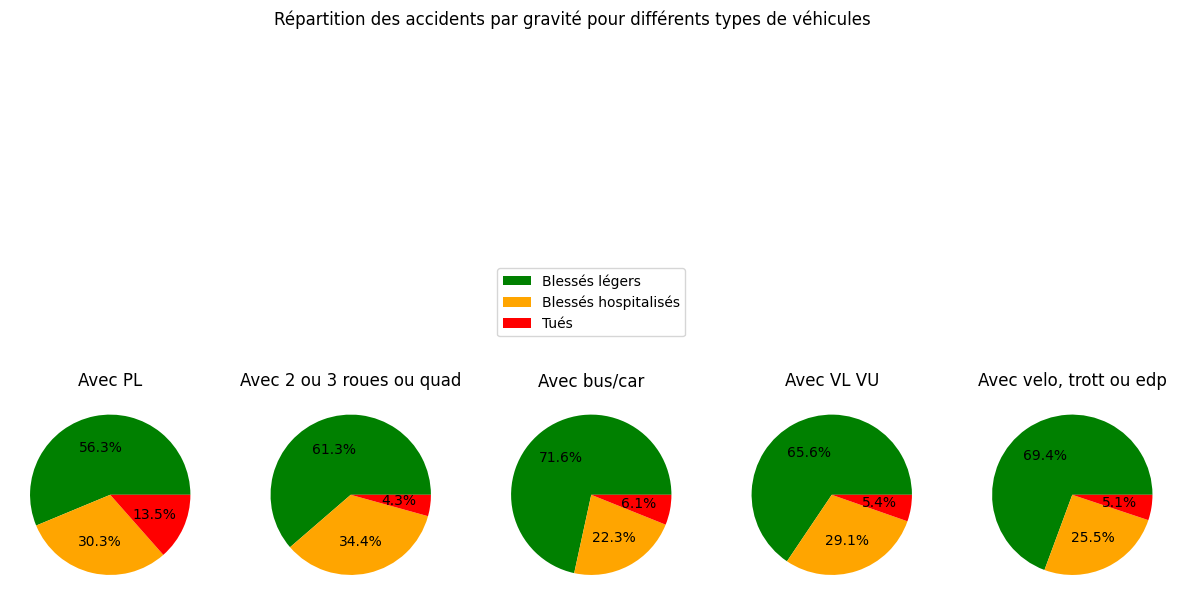

In [ ]:
# extraire tous df accidents où un PL est impliqué   9423 accidents
acc_avec_pl=df.loc[df["PL"]>=1]
acc_avec_pl=acc_avec_pl.groupby("gravité_accident").size()
print("proportion des gravités d'accidents impliquant au moins 1 PL",acc_avec_pl.div(acc_avec_pl.sum()))
# 13% des accidents impliquant au moins 1 PL sont mortels ; 30% avec blessés hospi

# extraire tous les accidents où un 2 ou 3 roues ou quad est impliqué   92608 accidents
acc_avec_2_3roues=df.loc[df["2roues_3roues_quad"]>=1]
acc_avec_2_3roues=acc_avec_2_3roues.groupby("gravité_accident").size()
print("proportion des gravités d'accidents impliquant au moins 1 2roues ou 3 roues ou quad ",acc_avec_2_3roues.div(acc_avec_2_3roues.sum()))

# idem pour Bus_Car
acc_avec_bus_car=df.loc[df["bus_car"]>=1]
acc_avec_bus_car=acc_avec_bus_car.groupby("gravité_accident").size()
print("proportion des gravités d'accidents impliquant au moins 1 bus ou car ", acc_avec_bus_car.div(acc_avec_bus_car.sum()))

# idem pour VL VU   222890 accidents

acc_av_vl_vu=df.loc[df["VL_VU"]>=1]
acc_av_vl_vu=acc_av_vl_vu.groupby("gravité_accident").size()
print("proportion des gravités d'accidents impliquant au moins 1 VL VU",acc_av_vl_vu.div(acc_av_vl_vu.sum()))

# idem pour velo trott et edp    45918 accidents
acc_av_velo_trott_edp=df.loc[df["velo_trott_edp"]>=1]
acc_av_velo_trott_edp=acc_av_velo_trott_edp.groupby("gravité_accident").size()
print("proportion des gravités d'accidents impliquant au moins 1 engin de déplacement personnel (velo, trott ou edp)",acc_av_velo_trott_edp.div(acc_av_velo_trott_edp.sum()))

fig,axs=plt.subplots(1,5,figsize=(15,10))
labels = ['Blessés légers', 'Blessés hospitalisés', 'Tués']

axs[0].pie(acc_avec_pl,colors=["green","orange","red"],autopct="%1.1f%%")
axs[0].set_title("Avec PL")
axs[1].pie(acc_avec_2_3roues,colors=["green","orange","red"],autopct="%1.1f%%")
axs[1].set_title("Avec 2 ou 3 roues ou quad")
axs[2].pie(acc_avec_bus_car,colors=["green","orange","red"],autopct="%1.1f%%")
axs[2].set_title("Avec bus/car")
axs[3].pie(acc_av_vl_vu,colors=["green","orange","red"],autopct="%1.1f%%")
axs[3].set_title("Avec VL VU")
axs[4].pie(acc_av_velo_trott_edp,colors=["green","orange","red"],autopct="%1.1f%%")
axs[4].set_title("Avec velo, trott ou edp")

fig.suptitle("Répartition des accidents par gravité pour différents types de véhicules")
fig.legend(labels, loc='center')

# idem pour piétons   44692 accidents
acc_av_pietons=df.loc[df["place_pieton"]>=1]
acc_av_pietons=acc_av_pietons.groupby("gravité_accident").size()
print("proportion des gravités d'accidents impliquant au moins 1 piéton",acc_av_pietons.div(acc_av_pietons.sum()))

Les accidents les plus graves sont ceux impliquant des tonneaux et des 2/3 roues. Les accidents les plus mortels sont ceux impliquant au moins un poids lourd.

Etude de la variable 'point de choc'

,gravité_accident,choc_AV,choc_AR,choc_cote,choc_tonneaux,aucun_choc
0,2,186844,59117,40695,3288,18392
1,3,89211,14133,16651,2617,8463
2,4,16528,2168,2450,639,1749


proportion des gravités d'accidents sans choc gravité_accident
2    0.574705
3    0.348100
4    0.077195
dtype: float64
proportion des gravités d'accidents impliquant au moins 1 choc AV gravité_accident
2    0.582759
3    0.346902
4    0.070338
dtype: float64
proportion des gravités d'accidents impliquant au moins 1  tonneau gravité_accident
2    0.424658
3    0.459241
4    0.116102
dtype: float64
proportion des gravités d'accidents impliquant au moins 1 choc AR gravité_accident
2    0.704381
3    0.250604
4    0.045015
dtype: float64
proportion des gravités d'accidents impliquant au moins 1 choc cote gravité_accident
2    0.643852
3    0.302578
4    0.053570
dtype: float64
proportion des gravités d'accidents impliquant plusieurs chocs gravité_accident
2    0.333333
3    0.333333
4    0.333333
dtype: float64


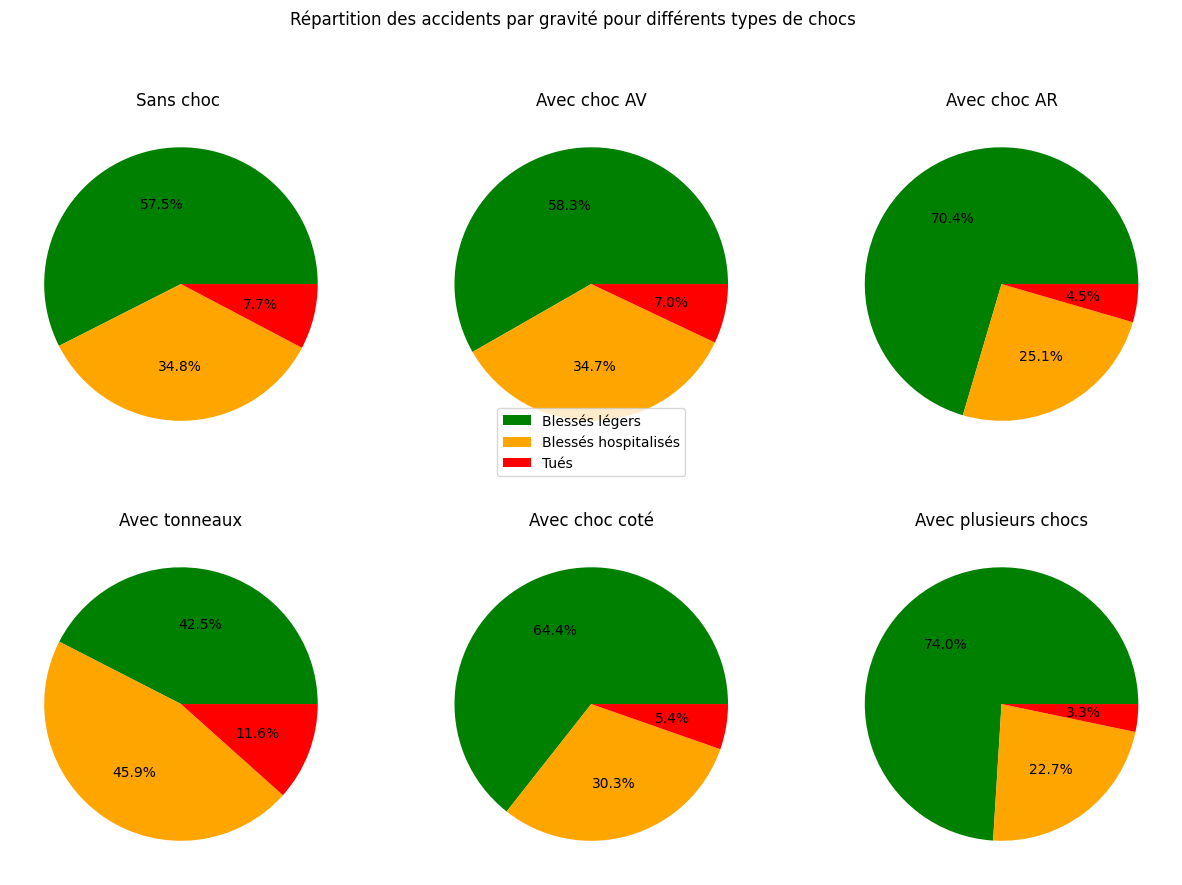

In [ ]:
import plotly.express as px

grav = df.groupby('gravité_accident').agg({'choc_AV':'sum', 'choc_AR': 'sum', 'choc_cote': 'sum', 'choc_tonneaux':'sum', 'aucun_choc':'sum'}).reset_index()
display(grav)
fig = px.bar(grav, x='gravité_accident', y=['choc_AV', 'choc_AR','choc_cote', 'choc_tonneaux','aucun_choc' ], title="Répartition du nombre d'accidents selon la gravité et le point de choc", barmode='group')
fig.update_xaxes(tickmode='array', tickvals=[2,3,4],ticktext=['blessé_léger', 'blessé_grave', 'tué'])
fig.show();

# Les chocs avant, arrière et tonneaux sont majoritaires. Etudions la répartition des accidents par  gravité pour chaque type de choc.

# # extraire les accidents pour lesquels il n'y a eu aucun choc    15869 accidents
acc_sans_choc=df.loc[(df["aucun_choc"]>=1)&(df["choc_AV"]==0)&(df["choc_AR"]==0)&(df["choc_tonneaux"]==0)&(df["choc_cote"]==0)]
acc_sans_choc
acc_sans_choc=acc_sans_choc.groupby("gravité_accident").size()
print("proportion des gravités d'accidents sans choc",acc_sans_choc.div(acc_sans_choc.sum()))


acc_av_choc_av=df.loc[(df["aucun_choc"]==0)&(df["choc_AV"]>=1)&(df["choc_AR"]==0)&(df["choc_tonneaux"]==0)&(df["choc_cote"]==0)]
acc_av_choc_av     # 131550 accidents
acc_av_choc_av=acc_av_choc_av.groupby("gravité_accident").size()
print("proportion des gravités d'accidents impliquant au moins 1 choc AV",acc_av_choc_av.div(acc_av_choc_av.sum()))

acc_av_tonneaux=df.loc[(df["aucun_choc"]==0)&(df["choc_AV"]==0)&(df["choc_AR"]==0)&(df["choc_tonneaux"]>=1)&(df["choc_cote"]==0)]
acc_av_tonneaux   # 4453 accidents
acc_av_tonneaux=acc_av_tonneaux.groupby("gravité_accident").size()
print("proportion des gravités d'accidents impliquant au moins 1  tonneau",acc_av_tonneaux.div(acc_av_tonneaux.sum()))

acc_av_choc_ar=df.loc[(df["aucun_choc"]==0)&(df["choc_AV"]==0)&(df["choc_AR"]>=1)&(df["choc_tonneaux"]==0)&(df["choc_cote"]==0)]
acc_av_choc_ar  # 6620 accidents
acc_av_choc_ar=acc_av_choc_ar.groupby("gravité_accident").size()
print("proportion des gravités d'accidents impliquant au moins 1 choc AR",acc_av_choc_ar.div(acc_av_choc_ar.sum()))

acc_av_choc_cote=df.loc[(df["aucun_choc"]==0)&(df["choc_AV"]==0)&(df["choc_AR"]==0)&(df["choc_tonneaux"]==0)&(df["choc_cote"]>=1)]
acc_av_choc_cote   # 16875 accidents
acc_av_choc_cote=acc_av_choc_cote.groupby("gravité_accident").size()
print("proportion des gravités d'accidents impliquant au moins 1 choc cote",acc_av_choc_cote.div(acc_av_choc_cote.sum()))

acc_chocs_multiples = df.loc[((df["choc_AV"] >= 1).astype(int) + (df["choc_AR"] >= 1).astype(int) + (df["choc_tonneaux"] >= 1).astype(int) + (df["choc_cote"] >= 1).astype(int)) >= 2]
acc_chocs_multiples=acc_chocs_multiples.groupby("gravité_accident").size()
print("proportion des gravités d'accidents impliquant plusieurs chocs",acc_chocs_multiples.groupby("gravité_accident").size().div(acc_chocs_multiples.groupby("gravité_accident").size().sum()))
labels = ['Blessés légers', 'Blessés hospitalisés', 'Tués']
fig,axs=plt.subplots(2,3,figsize=(15,10))

axs[0,0].pie(acc_sans_choc,colors=["green","orange","red"],autopct="%1.1f%%")
axs[0,0].set_title("Sans choc ")
axs[0,1].pie(acc_av_choc_av,colors=["green","orange","red"],autopct="%1.1f%%")
axs[0,1].set_title("Avec choc AV")
axs[0,2].pie(acc_av_choc_ar,colors=["green","orange","red"],autopct="%1.1f%%")
axs[0,2].set_title("Avec choc AR")
axs[1,0].pie(acc_av_tonneaux,colors=["green","orange","red"],autopct="%1.1f%%")
axs[1,0].set_title("Avec tonneaux")
axs[1,1].pie(acc_av_choc_cote,colors=["green","orange","red"],autopct="%1.1f%%")
axs[1,1].set_title("Avec choc coté")
axs[1,2].pie(acc_chocs_multiples,colors=["green","orange","red"],autopct="%1.1f%%")
axs[1,2].set_title("Avec plusieurs chocs")


fig.suptitle("Répartition des accidents par gravité pour différents types de chocs")
fig.legend(labels, loc='center')



# #  Le type de choc " tonneaux" impacte la gravité significativement ( blessés hospitalisés et tués )

On constate que les accidents les plus graves sont ceux pour lesquel il y a eu au moins un choc tonneaux. Ce sont également les plus mortels.

Variable 'Obstacle'

In [ ]:
obs = df.groupby('gravité_accident').agg({'obstacle_fixe':'sum', 'obstacle_mobile': 'sum'}).reset_index()
display(obs)
fig = px.bar(obs, x='gravité_accident', y=['obstacle_fixe', 'obstacle_mobile'], title="Répartition du nombre de véhicules par type d'obstacle selon la gravité", barmode='group')
fig.update_xaxes(tickmode='array', tickvals=[2,3,4],ticktext=['blessé_léger', 'blessé_grave', 'tué'])
fig.show();



On constate que pour toutes les catégories de gravité, il y a beacoup plus de collisions d'obstacles mobiles que d'obstacles fixes.

MATRICES DE CORRELATION

In [ ]:
# Suppression des variables non numériques ou non significatives pour les heatmaps
to_drop = [0,1,2,3,4,5,6,7,8,9,10,11]
df_filtré = df.drop(df.columns[to_drop], axis = 1)
print(df_filtré.info())


In [ ]:
# Pour plus de lisibilité, on fais=t plusieurs heatmaps sur des sélections de colonnes

# Matrice de corrélation usagers
selected_columns1 = [ 'usager_count', '0-17' ,'18-60', '61-95', 'gravité_accident','homme','femme', 'place_conducteur', 'pax_AV', 'pax_AR', 'pax_Milieu','place_pieton','blessé_léger', 'blessé_hospitalisé','tué']
corr_matrix_subset1 = df_filtré[selected_columns1].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_subset1, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.show()

On observe une corrélation positive entre la tranche d'âge 61_95 ans et la gravité de l'accident.
De même, on observe une corrélation positive entre le nombre d'hommes impliqués et la gravité de l'accident.

In [ ]:
# Matrice de corrélation selon les conditions de route
import numpy as np
df_filtré['nbv'] = df_filtré['nbv'].replace(to_replace = ['#ERREUR', '#VALEURMULTI'], value = np.nan)
selected_columns3 = ['gravité_accident','nationale_departementale_communale', 'autoroute', 'autre_route', 'sens_unique','vma','bidirectionnel','route_seche', 'route_mouillee_enneigee','etat_route_autre', 'nbv','blessé_léger', 'blessé_hospitalisé','tué']
corr_matrix_subset3 = df_filtré[selected_columns3].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_subset3, annot=True, cmap="coolwarm", linewidths=0.5,fmt=".2f" )
plt.show()

On observe une corrélation positive entre la vitesse maximale autorisée et la gravité de l'accident: plus la vitesse maximale autorisée augmente, plus la gravité de l'accident augmente.

On observe une corrélation positive forte entre la bidirectionnalité et la gravité

In [ ]:
# Autre matrice de corrélation: obstacles et types de chocs
selected_columns2 = ['gravité_accident', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc','choc_AV','choc_AR', 'choc_cote','choc_tonneaux','blessé_léger', 'blessé_hospitalisé','tué']
corr_matrix_subset2 = df_filtré[selected_columns2].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_subset2, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.show()

On observe une corrélation positive entre le nombre de véhicules ayant heurté un obstacle fixe et la gravité de l'accident. Et également une corrélation positive, mais moins forte, entre me nombre de véhicules ayant fait un choc_tonneaux et la gravité de l'accident.

In [ ]:
# Matrice de corrélation systèmes de sécurité
selected_columns4 = ['gravité_accident', 'total_sans_secu', 'total_ceinture', 'total_casque', 'total_secu_enfant', 'total_gilet','total_airbag','total_gants', 'total_gants_airbag', 'total_non_deter','total_autre']
corr_matrix_subset4 = df_filtré[selected_columns4].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_subset4, annot=True, cmap="coolwarm", linewidths=0.5,fmt=".2f" )
plt.show()

On observe une corrélation négative entre l'équipement sans sécurité et la gravité de l'accident. Ce la signifie que plus le nombre d'usagers sans système de sécurité augmente, plus la gravité de l'accident diminue.